# Notebook 2: The Steady State

## Setup

In [11]:
%load_ext autoreload
%autoreload 2

#import time
import pickle
import numpy as np
from datetime import datetime
import pandas as pd
import urllib.request
from fredapi import Fred
from sklearn.metrics import auc

import time
import numpy as np
from scipy import optimize

from consav.grids import equilogspace
from consav.markov import log_rouwenhorst
from consav.misc import elapsed
import matplotlib.pyplot as plt   

plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import matplotlib.pyplot as plt   
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams.update({'font.size': 12})

from consav.markov import tauchen, find_ergodic

from HANKSAMModel import HANKSAMModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = HANKSAMModelClass(name='baseline')

In [3]:
par = model.par
ss = model.ss
path = model.path
ini = model.ini

## Check, that the code works

In [4]:
# Set initial UI system
par.UI_ratio_high = 0.83
par.UI_ratio_low = 0.54
par.UI_duration = 6.0

In [30]:
model.find_ss(do_print=True)

Guess on L of: -0.05 causes diff L_guess - L_endo of: -0.11724643859252273
Guess on L of: 0.1 causes diff L_guess - L_endo of: 0.038741352581523135
Guess on L of: 0.06274578386237595 causes diff L_guess - L_endo of: 8.610394018766787e-05
Guess on L of: 0.06266286159620342 causes diff L_guess - L_endo of: 6.322617054910218e-09
Guess on L of: 0.06266285550677998 causes diff L_guess - L_endo of: 2.886579864025407e-15
Guess on L of: 0.06266285019346571 causes diff L_guess - L_endo of: -5.516782544678911e-09


In [24]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

shock_TFP      : 1.0000
delta          : 0.0275
w              : 0.7000
px             : 0.8333
Vj             : 3.8911
Vv             : 0.1000
entry          : 0.0267
mu             : 0.0201
M              : 0.1333
errors_Vj      : nan
vt             : 0.0413
S              : 0.0689
theta          : 0.6000
lambda_v       : 0.6368
lambda_u       : 0.3821
lambda_u_s     : 0.3821
v              : 0.0150
u              : 0.0426
ut             : 0.0689
errors_vt      : nan
errors_ut      : nan
errors_Vv      : nan
Pi             : 1.0000
errors_Pi      : nan
R              : 1.0017
RealR          : 1.0017
q              : 54.5904
RealR_ex_post  : 1.0017
tau            : 0.1363
B              : 0.0103
qB             : 0.5600
UI_ratio_high  : 0.8300
guess_U_UI     : 0.0402
UI_duration    : 6.0000
L              : 0.0695
shock_beta     : 1.0000
A_hh           : 0.5600
C_hh           : 0.6702
S_hh           : 0.0689
S_COND_hh      : 1.0000
U_UI_hh        : 0.0402
V_hh           : -462.1196
U_P

# Define functions

In [5]:
# Function for calculating gini coefficient

def gini(ss, par):
    
    D_new = np.sum(ss.D, axis = 0)
    
    # a. income
    inc_emp = par.a_grid*(ss.RealR-1) + ss.w*(1-par.tau) + ss.L
    inc_high = par.a_grid*(ss.RealR-1) + ss.w*(1-par.tau)*par.UI_ratio_high + ss.L 
    inc_low = par.a_grid*(ss.RealR-1) + ss.w*(1-par.tau)*par.UI_ratio_low + ss.L 
    
    #Distribution
    D_h = np.zeros((par.Na))
    D_l = np.zeros((par.Na))

    for i_a in range(par.Na):
        for i_z in range(par.Nz):
            if 0 < i_z < par.UI_duration + 1:
                D_h[i_a] += D_new[i_z,i_a] 
            elif i_z > par.UI_duration:
                D_l[i_a] += D_new[i_z,i_a]
    
    # Gini, total economy
    inc = np.concatenate((inc_low, inc_high, inc_emp))

    D_inc = np.concatenate((D_l, D_h, D_new[0]))

    inc_s, D_s = zip(*sorted(zip(inc, D_inc)))

    inc_s = tuple(ele1 * ele2 for ele1, ele2 in zip(inc_s, D_s))
    
    # Get Cumulative distribution
    x = np.insert(np.cumsum(D_s),0,0.0) 

    y_noscale = np.cumsum(inc_s)
    y = np.insert(y_noscale/y_noscale[-1],0,0.0)
    
    # calculate gini
    gini = (auc(y,y) - auc(x,y)) / auc(y,y)    
    
    return x, y, gini

In [6]:
# Function for calculating gini coefficient for only interest rate income

def gini_r(ss, par):
    
    D_new = np.sum(ss.D, axis = 0)
    
    D_r = np.sum(D_new,axis = 0)
    
    # a. income
    inc = par.a_grid*(ss.RealR-1)

    inc_s, D_s = zip(*sorted(zip(inc, D_r)))

    inc_s = tuple(ele1 * ele2 for ele1, ele2 in zip(inc_s, D_s))
    
    # Get Cumulative distribution
    x = np.insert(np.cumsum(D_s),0,0.0) 

    y_noscale = np.cumsum(inc_s)
    y = np.insert(y_noscale/y_noscale[-1],0,0.0)
    
    # calculate gini
    gini = (auc(y,y) - auc(x,y)) / auc(y,y)    
    
    return x, y, gini

In [7]:
#Function for calculating cumulative distribution functions 

def get_cum_dist(V, D):
 
    #Patient households
    D_pat = D[2]
    V_pat = V[2]
    
    D_pat_re = D_pat.reshape(par.Nz*par.Na)
    V_pat_re = V_pat.reshape(par.Nz*par.Na)
    
    V_pat_re_s, D_pat_re_s = (list(t) for t in zip(*sorted(zip(V_pat_re, D_pat_re))))


    D_pat_cum_noscale = np.cumsum(D_pat_re_s)
    D_pat_f = D_pat_cum_noscale/D_pat_cum_noscale[-1]
    
    V_pat_re_s = np.array(V_pat_re_s, dtype=float)
    D_pat_f = np.array(D_pat_f, dtype=float)
    
    #Impatient part of popuation
    D_im = D[1]
    V_im = V[1]
    
    D_im_re = D_im.reshape(par.Nz*par.Na)
    V_im_re = V_im.reshape(par.Nz*par.Na)
    
    V_im_re_s, D_im_re_s = (list(t) for t in zip(*sorted(zip(V_im_re, D_im_re))))


    D_im_cum_noscale = np.cumsum(D_im_re_s)
    D_im_f = D_im_cum_noscale/D_im_cum_noscale[-1]
    
    V_im_re_s = np.array(V_im_re_s, dtype=float)
    D_im_f = np.array(D_im_f, dtype=float)
    
    # HtM households
    D_htm = D[0]
    V_htm = V[0]
        
    D_htm_re = D_htm.reshape(par.Nz*par.Na)
    V_htm_re = V_htm.reshape(par.Nz*par.Na)
    
    V_htm_re_s, D_htm_re_s = (list(t) for t in zip(*sorted(zip(V_htm_re, D_htm_re))))


    D_htm_cum_noscale = np.cumsum(D_htm_re_s)
    D_htm_f = D_htm_cum_noscale/D_htm_cum_noscale[-1]
    
    V_htm_re_s = np.array(V_htm_re_s, dtype=float)
    D_htm_f = np.array(D_htm_f, dtype=float)

        
    return V_pat_re_s, D_pat_f, V_im_re_s, D_im_f, V_htm_re_s, D_htm_f 

#Function for calculating value function at percentiele
def get_perc(V_pat_re_s, D_pat_f, V_im_re_s, D_im_f, V_htm_re_s, D_htm_f, perc):
    U_pat = 0.0
    U_im = 0.0
    U_htm = 0.0
    
    #a. patient households
    for j in range(len(D_pat_f)):
        if D_pat_f[j] > perc and D_pat_f[j-1] < perc:
            U_pat = V_pat_re_s[j-1] + (perc - D_pat_f[j-1]) * (V_pat_re_s[j] - V_pat_re_s[j-1]) / (D_pat_f[j]-D_pat_f[j-1]) 
        else:
            pass

    #b. impatient households
    for k in range(len(D_im_f)):
        if D_im_f[k] > perc and D_im_f[k-1] < perc:
            U_im = V_im_re_s[k-1] + (perc - D_im_f[k-1]) * (V_im_re_s[k] - V_im_re_s[k-1]) / (D_im_f[k]-D_im_f[k-1]) 
        else:
            pass
    
    # c. HtM households
    for i in range(len(D_htm_f)):
        if D_htm_f[i] > perc and D_htm_f[i-1] < perc:
            U_htm = V_htm_re_s[i-1] + (perc - D_htm_f[i-1]) * (V_htm_re_s[i] - V_htm_re_s[i-1]) / (D_htm_f[i]-D_htm_f[i-1]) 
        else:
            pass
        
    return U_pat, U_im, U_htm

# Investigating the steady state

## Policy functions

Text(0, 0.5, 'search, $s_{t}$')

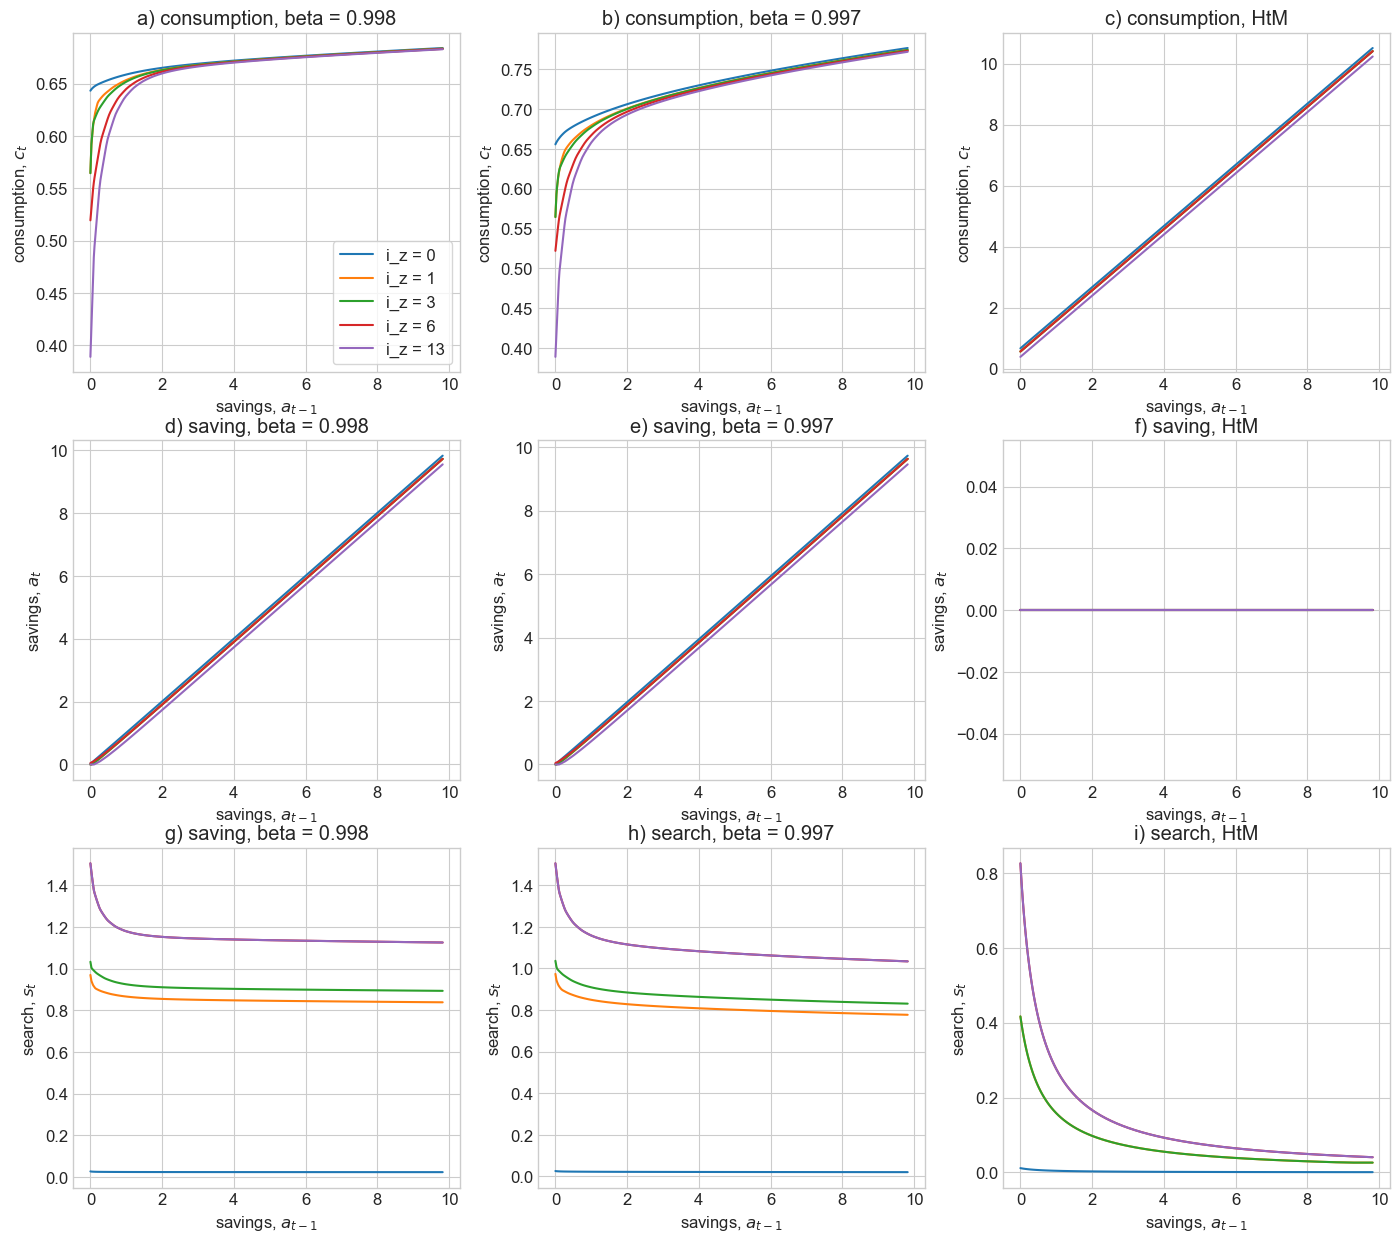

In [11]:
# Depict Policy Functions

beta_legend = par.beta_grid.round(3)

fig = plt.figure(figsize=(17,15),dpi=100)
a_max = 10

I = par.a_grid < a_max

k = 3

U_states = [0,1,3,6,13]

# a. consumption, patient
ax = fig.add_subplot(3,k,1)
ax.set_title(f'a) consumption, beta = 0.998')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.c[2,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. consumption, impatient
ax = fig.add_subplot(3,k,2)
ax.set_title(f'b) consumption, beta = 0.997')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.c[1,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# c. consumption, HTM
ax = fig.add_subplot(3,k,3)
ax.set_title(f'c) consumption, HtM')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# d. saving, patient
ax = fig.add_subplot(3,k,4)
ax.set_title(f'd) saving, beta = 0.998')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.a[2,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# d. saving, impatient
ax = fig.add_subplot(3,k,5)
ax.set_title(f'e) saving, beta = 0.997')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.a[1,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# d. saving, HTM
ax = fig.add_subplot(3,k,6)
ax.set_title(f'f) saving, HtM')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')
    
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')
    
# c. search, patient
ax = fig.add_subplot(3,k,7)
ax.set_title(f'g) saving, beta = 0.998')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.s[2,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_{t}$')

# c. search, impatient
ax = fig.add_subplot(3,k,8)
ax.set_title(f'h) search, beta = 0.997')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.s[1,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_{t}$')

# d. search, HTM
ax = fig.add_subplot(3,k,9)
ax.set_title(f'i) search, HtM')

for count, i_z in enumerate(U_states):
    ax.plot(par.a_grid[I],ss.s[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_{t}$')


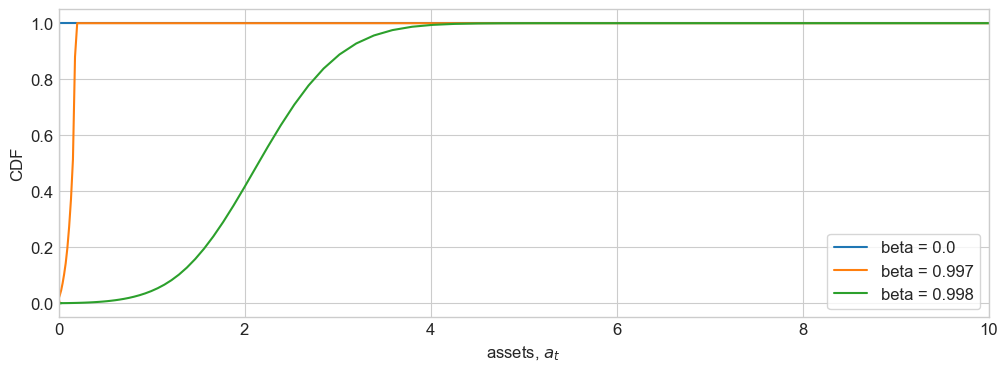

<Figure size 1200x400 with 0 Axes>

In [12]:
# Depict CDF

fig = plt.figure(figsize=(12,4),dpi=100)

# b. assets
ax = fig.add_subplot(1,1,1)
# ax.set_title('savings')
for i in range(par.Nfix):
    y = np.insert(np.cumsum(np.sum(ss.D[i],axis=0)),0,0.0)
    ax.plot(np.insert(par.a_grid,0,par.a_grid[i]),y/y[-1],label=f'beta = {par.beta_grid[i].round(3)}')
ax.set_xlim((0,10))
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
#ax.set_xscale('symlog')
fig = plt.figure(figsize=(12,4),dpi=100)
ax.legend(frameon=True)


## Varying parameters in the steady state

### Varying R

In [40]:
# Calculate the steady state  

par.UI_ratio_high = 0.83
par.UI_duration = 6.0


R_vec = [1.01, 1.015, 1.02, 1.025, 1.03]

A_R = np.nan + np.zeros(len(R_vec))
S_R = np.nan + np.zeros(len(R_vec))
C_R = np.nan + np.zeros(len(R_vec))
u_R = np.nan + np.zeros(len(R_vec))
betashare_R = np.nan + np.zeros((len(R_vec), len(par.beta_grid)))
lambda_u_R = np.nan + np.zeros(len(R_vec))
L_R = np.nan + np.zeros(len(R_vec))
u_UI_R = np.nan + np.zeros(len(R_vec))

for i in range(len(R_vec)):
    par.R_ss = R_vec[i]
    print(par.R_ss)
    model.find_ss()
    A_R[i] = ss.A_hh
    S_R[i] = ss.S_hh
    C_R[i] = ss.C_hh
    u_R[i] = ss.u
    betashare_R[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    lambda_u_R[i] = ss.lambda_u
    L_R[i] = ss.L
    u_UI_R[i] = ss.U_UI_hh

par.R_ss = 1.02

1.01
1.015
1.02
1.025
1.03


Text(0, 0.5, 'Fraction of population')

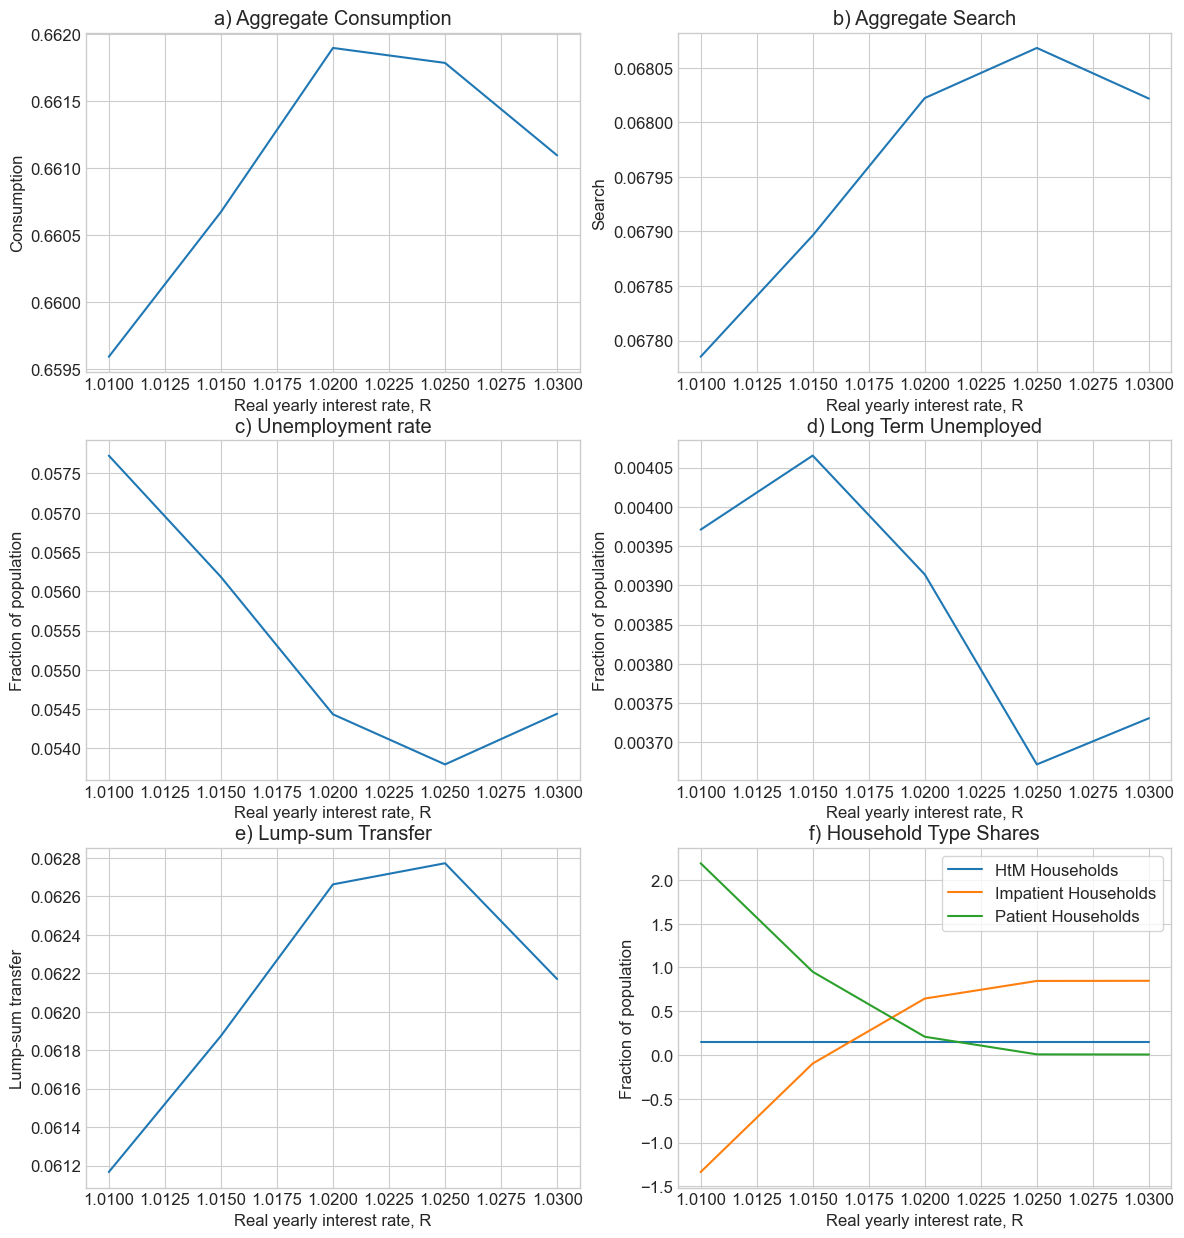

In [26]:
# Depict the results

fig = plt.figure(figsize=(14,15),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(3,2,1)
ax.set_title(f'a) Aggregate Consumption')

ax.plot(R_vec, C_R)

ax.set_xlabel('Real yearly interest rate, R')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(3,2,2)
ax.set_title(f'b) Aggregate Search')

ax.plot(R_vec, S_R)

ax.set_xlabel('Real yearly interest rate, R')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(3,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(R_vec, u_R)

ax.set_xlabel('Real yearly interest rate, R')
ax.set_ylabel('Fraction of population')

# d. Long-term unemployed
ax = fig.add_subplot(3,2,4)
ax.set_title(f'd) Long Term Unemployed')

ax.plot(R_vec, u_R - u_UI_R)

ax.set_xlabel('Real yearly interest rate, R')
ax.set_ylabel('Fraction of population')

# e. Lump-sum Transfers
ax = fig.add_subplot(3,2,5)
ax.set_title(f'e) Lump-sum Transfer')

ax.plot(R_vec, L_R)

ax.set_xlabel('Real yearly interest rate, R')
ax.set_ylabel('Lump-sum transfer')

# f. Type fractions
ax = fig.add_subplot(3,2,6)
ax.set_title(f'f) Household Type Shares')

ax.plot(R_vec, betashare_R[:,0], label = f'HtM Households')
ax.plot(R_vec, betashare_R[:,1], label = f'Impatient Households')
ax.plot(R_vec, betashare_R[:,2], label = f'Patient Households')
        
ax.legend(frameon = True)

ax.set_xlabel('Real yearly interest rate, R')
ax.set_ylabel('Fraction of population')


In [15]:
# Calculate Policy functions

R_vec = [1.01, 1.015, 1.02, 1.025, 1.03]


a_R = np.nan + np.zeros((len(R_vec), par.Nfix, par.Nz, par.Na))
c_R = np.nan + np.zeros((len(R_vec), par.Nfix, par.Nz, par.Na))
s_R = np.nan + np.zeros((len(R_vec), par.Nfix, par.Nz, par.Na))


for i in range(len(R_vec)):
    ss.RealR = ss.RealR_ex_post = R_vec[i]**(1/12)
    print(R_vec[i])
    
    ss.shock_TFP = 1.0
    ss.shock_beta = 1.0
    
    ss.w = par.w_ss

    ss.UI_ratio_high = par.UI_ratio_high
    ss.UI_duration = par.UI_duration
    ss.tau = par.tau        
    ss.delta = par.delta_ss

    ss.qB = par.qB_share_ss*ss.w
    
    ss.L = 0.05413311163047142
    
    ss.lambda_u_s = par.lambda_u_s_ss
    
    model.solve_hh_ss()
    
    a_R[i] = ss.a
    c_R[i] = ss.c
    s_R[i] = ss.s

1.01
1.015
1.02
1.025
1.03


Text(0, 0.5, 'search, $s_t$')

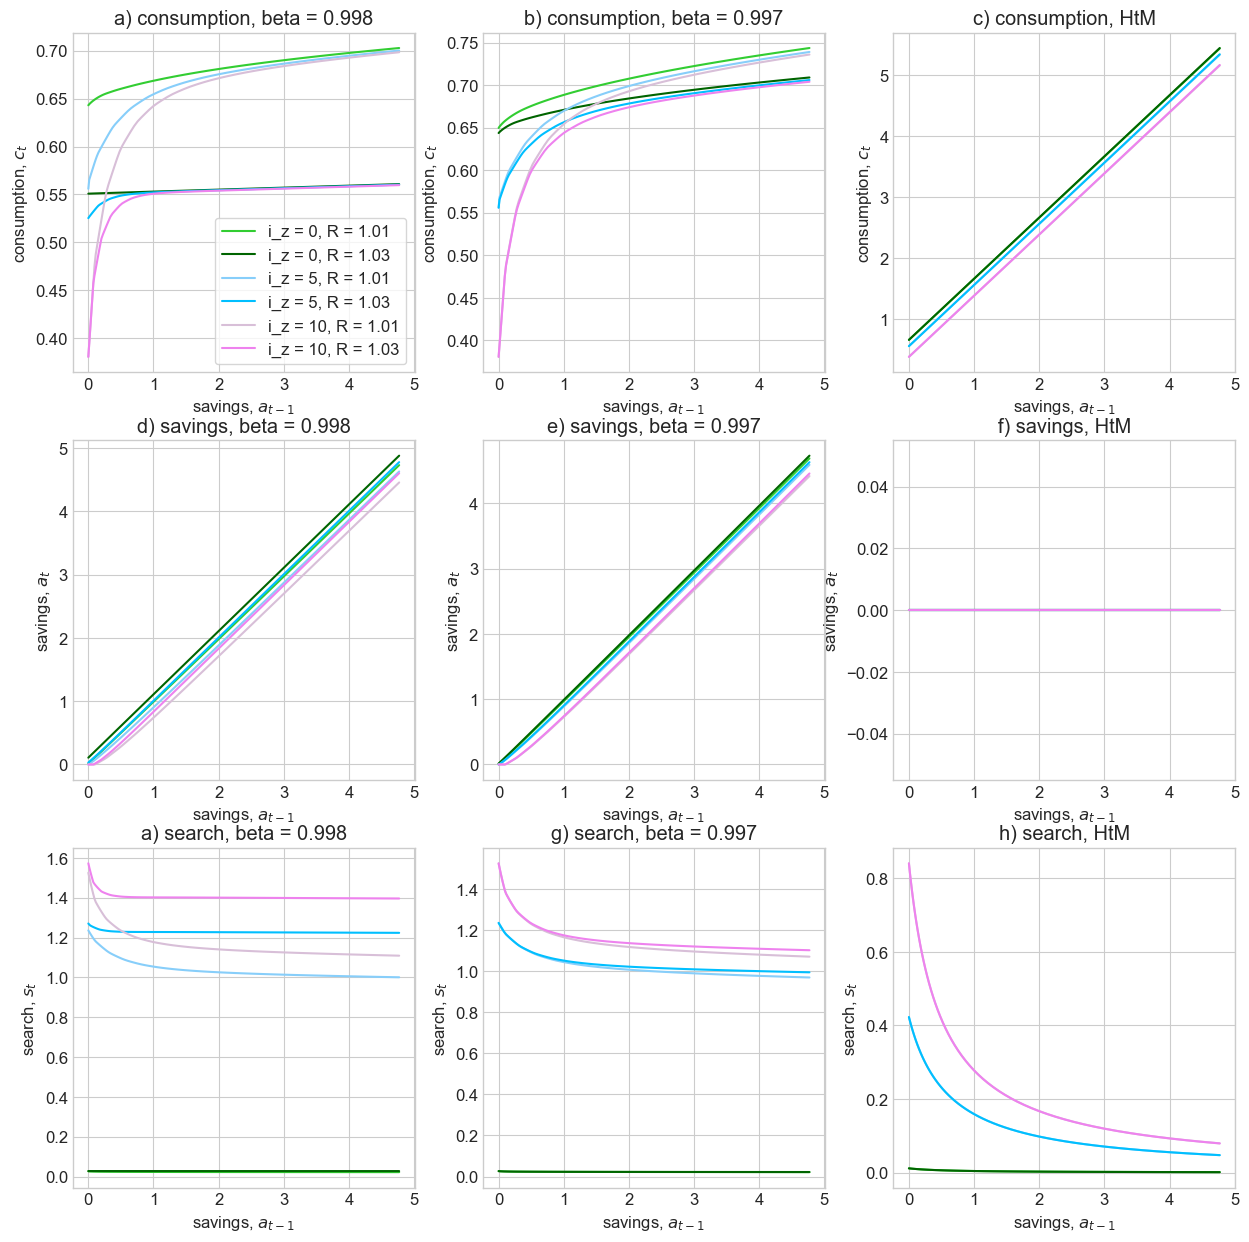

In [16]:
beta_legend = par.beta_grid.round(3)

fig = plt.figure(figsize=(15,15),dpi=100)
a_max = 5

I = par.a_grid < a_max

r = 3
k = 3

i_z = 0
i_R = 2

U_states = [0,5,10]
R_index = [0,2,4]


# a. consumption, patient
ax = fig.add_subplot(r,k,1)
ax.set_title(f'a) consumption, beta = 0.998')

ax.plot(par.a_grid[I],c_R[0,2,0,I],label=f'i_z = {0}, R = {R_vec[0]}', color = 'limegreen')
#ax.plot(par.a_grid[I],a_R[2,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],c_R[4,2,0,I],label=f'i_z = {0}, R = {R_vec[4]}', color = 'darkgreen')
ax.plot(par.a_grid[I],c_R[0,2,5,I],label=f'i_z = {5}, R = {R_vec[0]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],a_R[2,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],c_R[4,2,5,I],label=f'i_z = {5}, R = {R_vec[4]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],c_R[0,2,10,I],label=f'i_z = {10}, R = {R_vec[0]}', color = 'thistle')
#ax.plot(par.a_grid[I],a_R[2,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],c_R[4,2,10,I],label=f'i_z = {10}, R = {R_vec[4]}', color = 'violet')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. consumption, impatient
ax = fig.add_subplot(r,k,2)
ax.set_title(f'b) consumption, beta = 0.997')

ax.plot(par.a_grid[I],c_R[0,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],a_R[2,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],c_R[4,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],c_R[0,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],a_R[2,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],c_R[4,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],c_R[0,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],a_R[2,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],c_R[4,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# c. consumption, HTM
ax = fig.add_subplot(r,k,3)
ax.set_title(f'c) consumption, HtM')

ax.plot(par.a_grid[I],c_R[0,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],a_R[2,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],c_R[4,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],c_R[0,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],a_R[2,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],c_R[4,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],c_R[0,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],a_R[2,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],c_R[4,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# d. saving, patient
ax = fig.add_subplot(r,k,4)
ax.set_title(f'd) savings, beta = 0.998')

ax.plot(par.a_grid[I],a_R[0,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],c_R[2,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],a_R[4,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],a_R[0,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],c_R[2,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],a_R[4,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],a_R[0,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],c_R[2,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],a_R[4,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_t$')

# d. saving, impatient
ax = fig.add_subplot(r,k,5)
ax.set_title(f'e) savings, beta = 0.997')

ax.plot(par.a_grid[I],a_R[0,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],c_R[2,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],a_R[4,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],a_R[0,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],c_R[2,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],a_R[4,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],a_R[0,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],c_R[2,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],a_R[4,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_t$')

# d. saving, HTM
ax = fig.add_subplot(r,k,6)
ax.set_title(f'f) savings, HtM')

ax.plot(par.a_grid[I],a_R[0,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],c_R[2,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],a_R[4,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],a_R[0,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],c_R[2,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],a_R[4,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],a_R[0,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],c_R[2,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],a_R[4,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_t$')

ax = fig.add_subplot(r,k,7)
ax.set_title(f'a) search, beta = 0.998')

ax.plot(par.a_grid[I],s_R[0,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],s_R[2,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],s_R[4,2,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],s_R[0,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],s_R[2,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],s_R[4,2,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],s_R[0,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],s_R[2,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],s_R[4,2,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_t$')

ax = fig.add_subplot(r,k,8)
ax.set_title(f'g) search, beta = 0.997')

ax.plot(par.a_grid[I],s_R[0,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],c_R[2,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],s_R[4,1,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],s_R[0,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],c_R[2,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],s_R[4,1,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],s_R[0,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],c_R[2,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],s_R[4,1,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_t$')

ax = fig.add_subplot(r,k,9)
ax.set_title(f'h) search, HtM')

ax.plot(par.a_grid[I],s_R[0,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'limegreen')
#ax.plot(par.a_grid[I],s_R[2,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'forestgreen')
ax.plot(par.a_grid[I],s_R[4,0,0,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'darkgreen')
ax.plot(par.a_grid[I],s_R[0,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'lightskyblue')
#ax.plot(par.a_grid[I],s_R[2,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],s_R[4,0,5,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'deepskyblue')
ax.plot(par.a_grid[I],s_R[0,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'thistle')
#ax.plot(par.a_grid[I],s_R[2,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'plum')
ax.plot(par.a_grid[I],s_R[4,0,10,I],label=f'i_z = {i_z}, R = {R_vec[i_R]}', color = 'violet')


ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('search, $s_t$')


### Varying the cost of search

In [17]:
# Calculate the steady state  

phi_vec = [0.35, 0.425, 0.5, 0.575, 0.65]

A_phi = np.nan + np.zeros(len(phi_vec))
S_phi = np.nan + np.zeros(len(phi_vec))
C_phi = np.nan + np.zeros(len(phi_vec))
u_phi = np.nan + np.zeros(len(phi_vec))
betashare_phi = np.nan + np.zeros((len(phi_vec), len(par.beta_grid)))
lambda_u_phi = np.nan + np.zeros(len(phi_vec))
L_phi = np.nan + np.zeros(len(phi_vec))
u_UI_phi = np.nan + np.zeros(len(phi_vec))

for i in range(len(phi_vec)):
    par.varphi = phi_vec[i]
    print(par.varphi)
    model.find_ss()
    A_phi[i] = ss.A_hh
    S_phi[i] = ss.S_hh
    C_phi[i] = ss.C_hh
    u_phi[i] = ss.u
    L_phi[i] = ss.L
    u_UI_phi[i] = ss.U_UI_hh
    betashare_phi[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    
par.varphi = 0.5

0.35
0.425
0.5
0.575
0.65


Text(0, 0.5, 'Fraction of population')

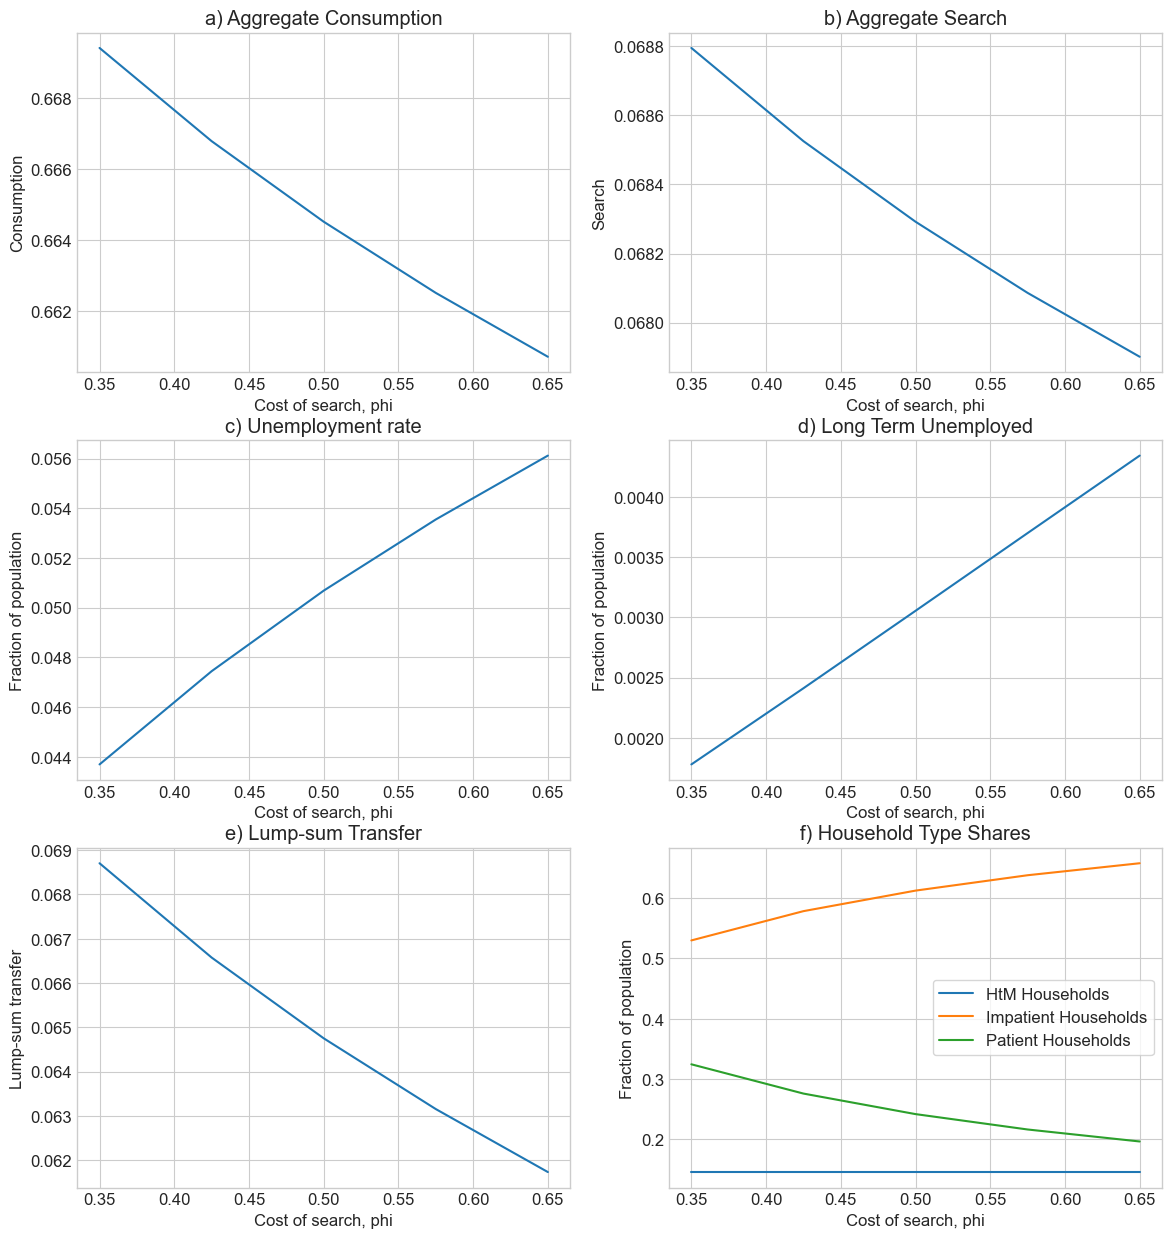

In [27]:
# Depict the results

fig = plt.figure(figsize=(14,15),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(3,2,1)
ax.set_title(f'a) Aggregate Consumption')

ax.plot(phi_vec, C_phi)

ax.set_xlabel('Cost of search, phi')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(3,2,2)
ax.set_title(f'b) Aggregate Search')

ax.plot(phi_vec, S_phi)

ax.set_xlabel('Cost of search, phi')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(3,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(phi_vec, u_phi)

ax.set_xlabel('Cost of search, phi')
ax.set_ylabel('Fraction of population')

# d. Long-term unemployed
ax = fig.add_subplot(3,2,4)
ax.set_title(f'd) Long Term Unemployed')

ax.plot(phi_vec, u_phi - u_UI_phi)

ax.set_xlabel('Cost of search, phi')
ax.set_ylabel('Fraction of population')

# e. Lump-sum Transfers
ax = fig.add_subplot(3,2,5)
ax.set_title(f'e) Lump-sum Transfer')

ax.plot(phi_vec, L_phi)

ax.set_xlabel('Cost of search, phi')
ax.set_ylabel('Lump-sum transfer')

# f. Type fractions
ax = fig.add_subplot(3,2,6)
ax.set_title(f'f) Household Type Shares')

ax.plot(phi_vec, betashare_phi[:,0], label = f'HtM Households')
ax.plot(phi_vec, betashare_phi[:,1], label = f'Impatient Households')
ax.plot(phi_vec, betashare_phi[:,2], label = f'Patient Households')
        
ax.legend(frameon = True)

ax.set_xlabel('Cost of search, phi')
ax.set_ylabel('Fraction of population')

### Varying fraction of HtM

In [19]:
# Calculate the steady state  

htm_vec = [0.11, 0.13, 0.15, 0.17, 0.19]

A_htm = np.nan + np.zeros(len(htm_vec))
S_htm = np.nan + np.zeros(len(htm_vec))
C_htm = np.nan + np.zeros(len(htm_vec))
u_htm = np.nan + np.zeros(len(htm_vec))
betashare_htm = np.nan + np.zeros((len(htm_vec), len(par.beta_grid)))
lambda_u_htm = np.nan + np.zeros(len(htm_vec))
L_htm = np.nan + np.zeros(len(htm_vec))
u_UI_htm = np.nan + np.zeros(len(htm_vec))

for i in range(len(htm_vec)):
    par.HtM_share = htm_vec[i]
    print(par.HtM_share)
    model.find_ss()
    A_htm[i] = ss.A_hh
    S_htm[i] = ss.S_hh
    C_htm[i] = ss.C_hh
    u_htm[i] = ss.u
    betashare_htm[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    lambda_u_htm[i] = ss.lambda_u
    L_htm[i] = ss.L
    u_UI_htm[i] = ss.U_UI_hh
    
par.HtM_share = 0.14313

0.11
0.13
0.15
0.17
0.19


Text(0, 0.5, 'Fraction of population')

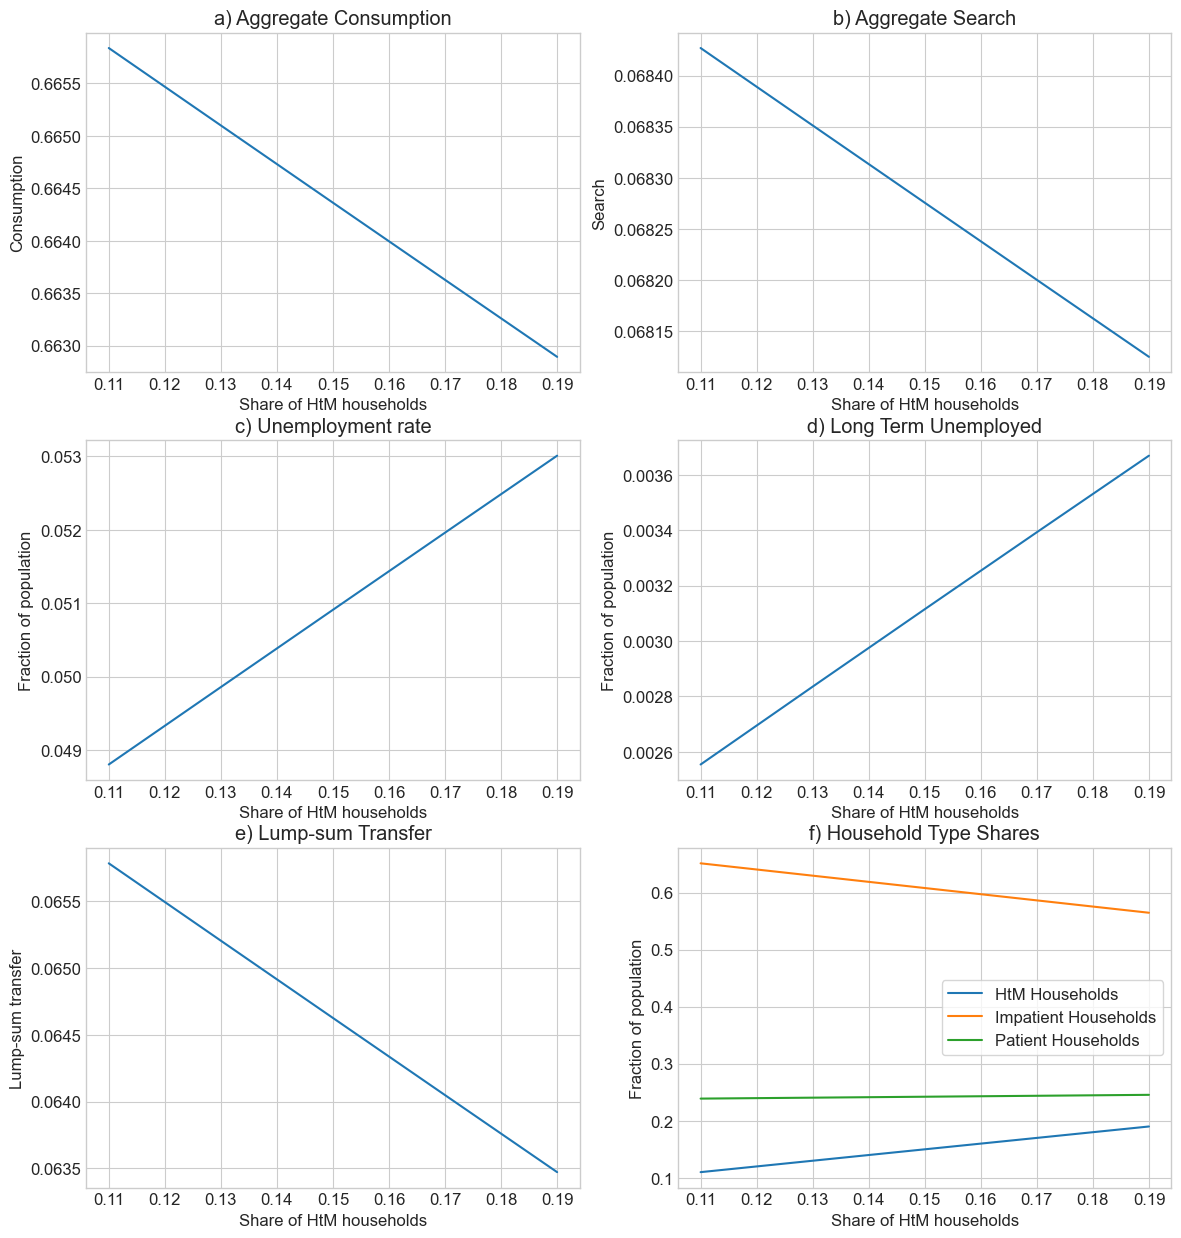

In [30]:
# Depict the results

fig = plt.figure(figsize=(14,15),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(3,2,1)
ax.set_title(f'a) Aggregate Consumption')

ax.plot(htm_vec, C_htm)

ax.set_xlabel('Share of HtM households')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(3,2,2)
ax.set_title(f'b) Aggregate Search')

ax.plot(htm_vec, S_htm)

ax.set_xlabel('Share of HtM households')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(3,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(htm_vec, u_htm)

ax.set_xlabel('Share of HtM households')
ax.set_ylabel('Fraction of population')

# d. Long-term unemployed
ax = fig.add_subplot(3,2,4)
ax.set_title(f'd) Long Term Unemployed')

ax.plot(htm_vec, u_htm - u_UI_htm)

ax.set_xlabel('Share of HtM households')
ax.set_ylabel('Fraction of population')

# e. Lump-sum Transfers
ax = fig.add_subplot(3,2,5)
ax.set_title(f'e) Lump-sum Transfer')

ax.plot(htm_vec, L_htm)

ax.set_xlabel('Share of HtM households')
ax.set_ylabel('Lump-sum transfer')

# f. Type fractions
ax = fig.add_subplot(3,2,6)
ax.set_title(f'f) Household Type Shares')

ax.plot(htm_vec, betashare_htm[:,0], label = f'HtM Households')
ax.plot(htm_vec, betashare_htm[:,1], label = f'Impatient Households')
ax.plot(htm_vec, betashare_htm[:,2], label = f'Patient Households')
        
ax.legend(frameon = True)

ax.set_xlabel('Share of HtM households')
ax.set_ylabel('Fraction of population')


### Varying qB

In [21]:
# Calculate the steady state  

qB_vec = [0.7, 0.75, 0.8, 0.85, 0.9]

A_qB = np.nan + np.zeros(len(qB_vec))
S_qB = np.nan + np.zeros(len(qB_vec))
C_qB = np.nan + np.zeros(len(qB_vec))
u_qB = np.nan + np.zeros(len(qB_vec))
betashare_qB = np.nan + np.zeros((len(qB_vec), len(par.beta_grid)))
lambda_u_qB = np.nan + np.zeros(len(qB_vec))
L_qB = np.nan + np.zeros(len(qB_vec))
u_UI_qB = np.nan + np.zeros(len(qB_vec))


for i in range(len(qB_vec)):
    par.qB_share_ss = qB_vec[i]
    print(par.qB_share_ss)
    model.find_ss()
    A_qB[i] = ss.A_hh
    S_qB[i] = ss.S_hh
    C_qB[i] = ss.C_hh
    u_qB[i] = ss.u
    betashare_qB[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    lambda_u_qB[i] = ss.lambda_u
    L_qB[i] = ss.L
    u_UI_qB[i] = ss.U_UI_hh
    
par.qB_share_ss = 0.8

0.7
0.75
0.8
0.85
0.9


Text(0, 0.5, 'Fraction of population')

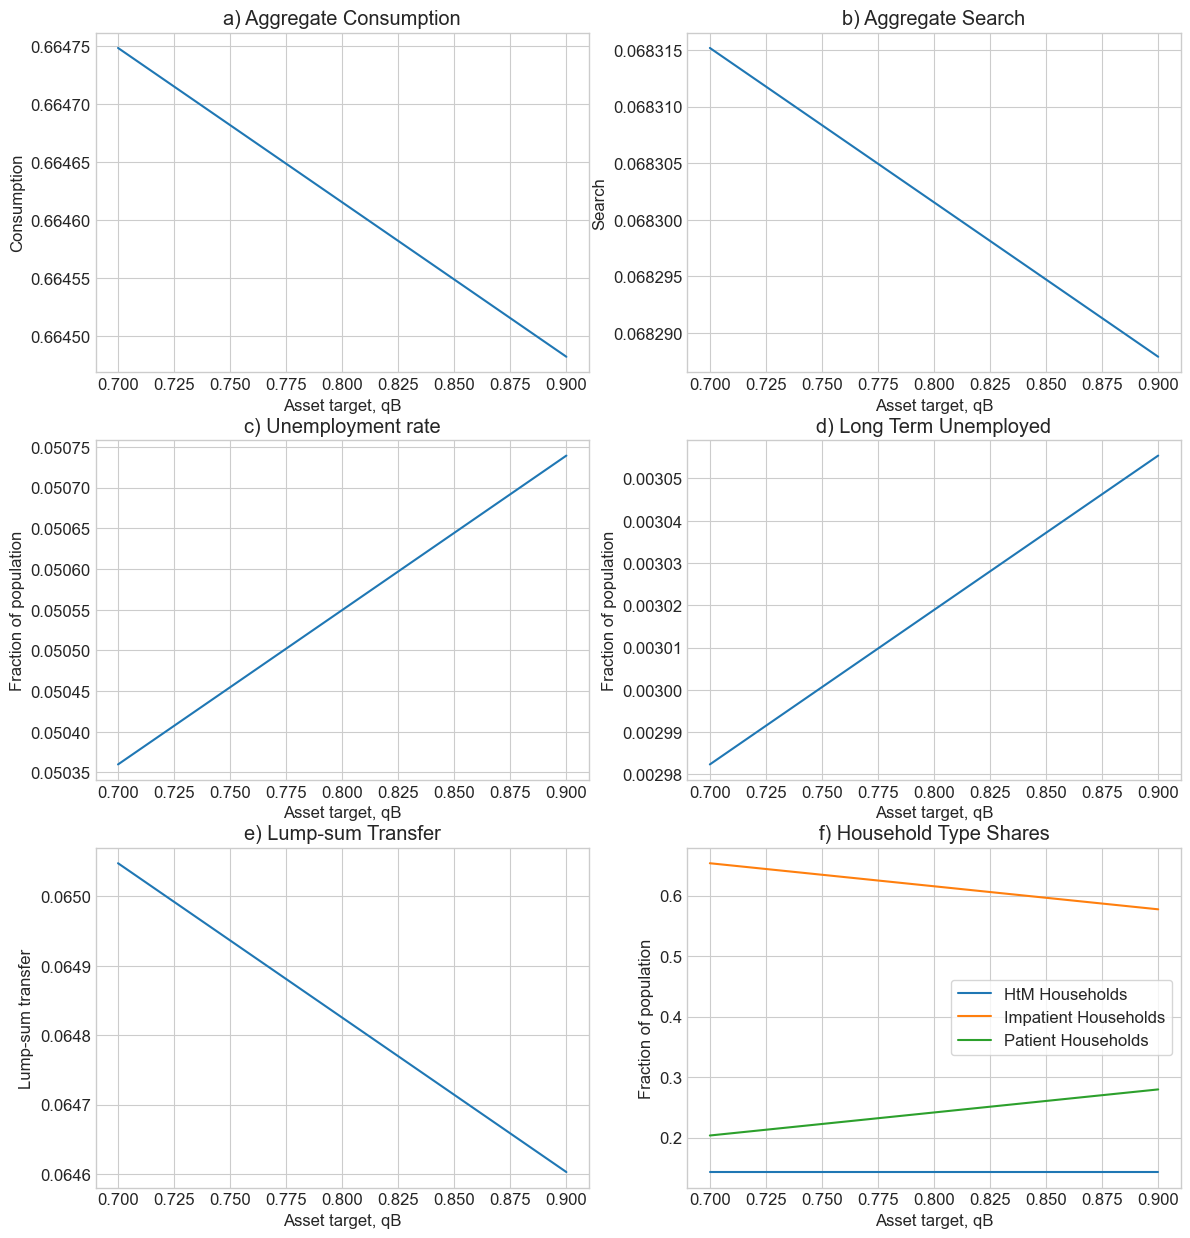

In [28]:
# Depict the results

fig = plt.figure(figsize=(14,15),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(3,2,1)
ax.set_title(f'a) Aggregate Consumption')

ax.plot(qB_vec, C_qB)

ax.set_xlabel('Asset target, qB')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(3,2,2)
ax.set_title(f'b) Aggregate Search')

ax.plot(qB_vec, S_qB)

ax.set_xlabel('Asset target, qB')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(3,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(qB_vec, u_qB)

ax.set_xlabel('Asset target, qB')
ax.set_ylabel('Fraction of population')

# d. Long-term unemployed
ax = fig.add_subplot(3,2,4)
ax.set_title(f'd) Long Term Unemployed')

ax.plot(qB_vec, u_qB - u_UI_qB)

ax.set_xlabel('Asset target, qB')
ax.set_ylabel('Fraction of population')

# e. Lump-sum Transfers
ax = fig.add_subplot(3,2,5)
ax.set_title(f'e) Lump-sum Transfer')

ax.plot(qB_vec, L_qB)

ax.set_xlabel('Asset target, qB')
ax.set_ylabel('Lump-sum transfer')

# f. Type fractions
ax = fig.add_subplot(3,2,6)
ax.set_title(f'f) Household Type Shares')

ax.plot(qB_vec, betashare_qB[:,0], label = f'HtM Households')
ax.plot(qB_vec, betashare_qB[:,1], label = f'Impatient Households')
ax.plot(qB_vec, betashare_qB[:,2], label = f'Patient Households')
        
ax.legend(frameon = True)

ax.set_xlabel('Asset target, qB')
ax.set_ylabel('Fraction of population')


### Varying lambda_us

In [23]:
# Calculate the steady state  

leff_vec = [0.275, 0.3125, 0.35, 0.3875, 0.425]

A_leff = np.nan + np.zeros(len(leff_vec))
S_leff = np.nan + np.zeros(len(leff_vec))
C_leff = np.nan + np.zeros(len(leff_vec))
u_leff = np.nan + np.zeros(len(leff_vec))
betashare_leff = np.nan + np.zeros((len(leff_vec), len(par.beta_grid)))
lambda_u_leff = np.nan + np.zeros(len(leff_vec))
L_leff = np.nan + np.zeros(len(leff_vec))
u_UI_leff = np.nan + np.zeros(len(leff_vec))


for i in range(len(leff_vec)):
    par.lambda_u_s_ss = leff_vec[i]
    print(par.lambda_u_s_ss)
    model.find_ss()
    A_leff[i] = ss.A_hh
    S_leff[i] = ss.S_hh
    C_leff[i] = ss.C_hh
    u_leff[i] = ss.u
    betashare_leff[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    lambda_u_leff[i] = ss.lambda_u
    L_leff[i] = ss.L
    u_UI_leff[i] = ss.U_UI_hh
    
par.lambda_u_s_ss =  0.3820788784109759

0.275
0.3125
0.35
0.3875
0.425


Text(0, 0.5, 'Fraction of population')

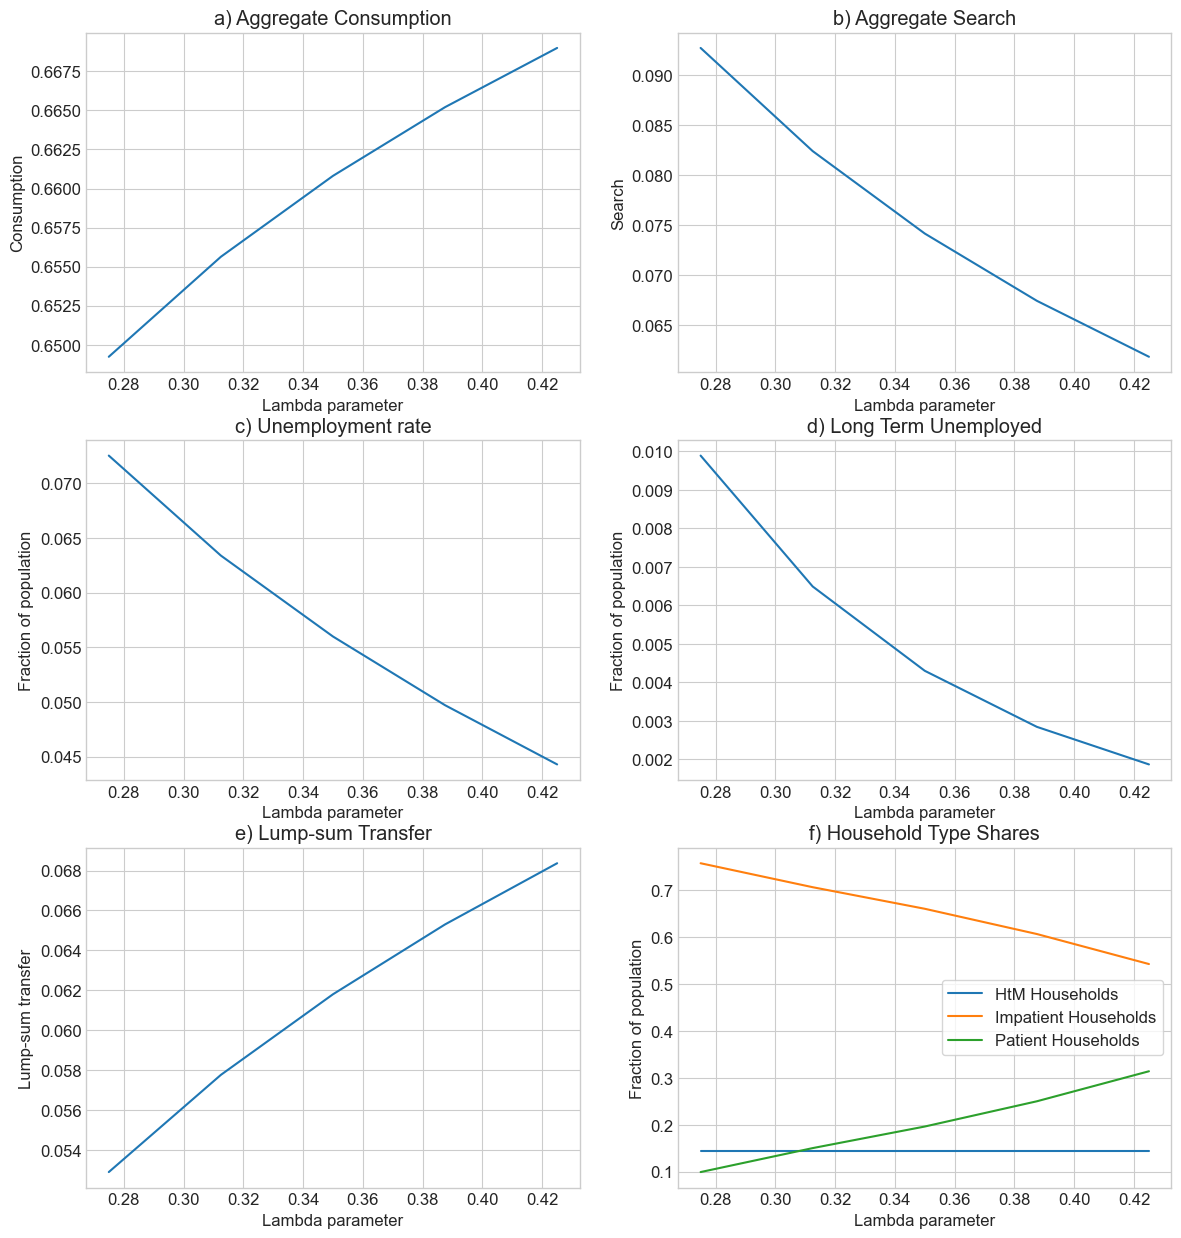

In [29]:
# Depict the results

fig = plt.figure(figsize=(14,15),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(3,2,1)
ax.set_title(f'a) Aggregate Consumption')

ax.plot(leff_vec, C_leff)

ax.set_xlabel('Lambda parameter')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(3,2,2)
ax.set_title(f'b) Aggregate Search')

ax.plot(leff_vec, S_leff)

ax.set_xlabel('Lambda parameter')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(3,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(leff_vec, u_leff)

ax.set_xlabel('Lambda parameter')
ax.set_ylabel('Fraction of population')

# d. Long-term unemployed
ax = fig.add_subplot(3,2,4)
ax.set_title(f'd) Long Term Unemployed')

ax.plot(leff_vec, u_leff - u_UI_leff)

ax.set_xlabel('Lambda parameter')
ax.set_ylabel('Fraction of population')

# e. Lump-sum Transfers
ax = fig.add_subplot(3,2,5)
ax.set_title(f'e) Lump-sum Transfer')

ax.plot(leff_vec, L_leff)

ax.set_xlabel('Lambda parameter')
ax.set_ylabel('Lump-sum transfer')

# f. Type fractions
ax = fig.add_subplot(3,2,6)
ax.set_title(f'f) Household Type Shares')

ax.plot(leff_vec, betashare_leff[:,0], label = f'HtM Households')
ax.plot(leff_vec, betashare_leff[:,1], label = f'Impatient Households')
ax.plot(leff_vec, betashare_leff[:,2], label = f'Patient Households')
        
ax.legend(frameon = True)

ax.set_xlabel('Lambda parameter')
ax.set_ylabel('Fraction of population')

# Optimal UI Ratio in The Steady State

In [125]:
# Compute ss for different UI ratios

UI_ratio_vec = np.linspace(0.54, 1.1, 29)

# Search
S_UI = np.nan + np.zeros(len(UI_ratio_vec))
S_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
s_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
s_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
s_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#savings 
A_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

a_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
a_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# Consumption
C_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

C_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# Unemployment rates
u_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))
    
# Long term unemployed
u_UI_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#ut unemployed
ut_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#Unemployment fractions
frac_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
frac_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
frac_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

fracl_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
fracl_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
fracl_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# Other aggregates
betashare_UI = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
V_UI = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
L_UI = np.nan + np.zeros(len(UI_ratio_vec))
lambda_u_UI = np.nan + np.zeros(len(UI_ratio_vec))

# for fractiles
D_f = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
V_f = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

Dbeg_UI = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

# Gini
gini_UI = np.nan + np.zeros(len(UI_ratio_vec))
gini_r_UI = np.nan + np.zeros(len(UI_ratio_vec))

for i in range(len(UI_ratio_vec)):
    par.UI_ratio_high = UI_ratio_vec[i]
    print(par.UI_ratio_high)
    model.find_ss()
    
    # Search
    S_UI[i] = ss.S
    S_UI_pol[i] = ss.s
    Dbeg_UI[i] = ss.Dbeg 
    
    s_htm_UI[i] = np.sum(ss.s[0]*ss.Dbeg[0]) / np.sum(ss.Dbeg[0])
    s_im_UI[i] = np.sum(ss.s[1]*ss.Dbeg[1]) / np.sum(ss.Dbeg[1])
    s_pat_UI[i] = np.sum(ss.s[2]*ss.Dbeg[2]) / np.sum(ss.Dbeg[2])
    
    #savings 
    A_UI_pol[i] = ss.a
    
    a_im_UI[i] = np.sum(ss.a[1]*ss.D[1]) / np.sum(ss.D[1])
    a_pat_UI[i] = np.sum(ss.a[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # Consumption
    C_UI_pol[i] = ss.c
    C_UI[i] = ss.C_hh
    
    c_htm_UI[i] = np.sum(ss.c[0]*ss.D[0]) / np.sum(ss.D[0])
    c_im_UI[i] = np.sum(ss.c[1]*ss.D[1]) / np.sum(ss.D[1])
    c_pat_UI[i] = np.sum(ss.c[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # unemployment rates
    u_UI[i] = ss.u
    
    u_htm_UI[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    u_im_UI[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    u_pat_UI[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])
    
    # Long term unemployed
    u_UI_UI[i] = ss.U_UI_hh
    
    u_UI_htm_UI[i] = np.sum(ss.u_UI[0]*ss.D[0]) / np.sum(ss.D[0])
    u_UI_im_UI[i] = np.sum(ss.u_UI[1]*ss.D[1]) / np.sum(ss.D[1])
    u_UI_pat_UI[i] = np.sum(ss.u_UI[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #ut unemployed
    ut_UI[i] = ss.ut
    
    ut_htm_UI[i] = (ss.delta*np.sum(ss.D[0,0]) + np.sum(ss.D[0,1:]))  / np.sum(ss.D[0])
    ut_im_UI[i] = (ss.delta*np.sum(ss.D[1,0]) + np.sum(ss.D[1,1:])) / np.sum(ss.D[1])
    ut_pat_UI[i] = (ss.delta*np.sum(ss.D[2,0]) + np.sum(ss.D[2,1:])) / np.sum(ss.D[2])
    
    #Fractions of total unemployment
    frac_htm_UI[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    frac_im_UI[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    frac_pat_UI[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])

    fracl_htm_UI[i] = np.sum(ss.D[0,7:]) / np.sum(ss.D[0])
    fracl_im_UI[i] = np.sum(ss.D[1,7:]) / np.sum(ss.D[1])
    fracl_pat_UI[i] = np.sum(ss.D[2,7:]) / np.sum(ss.D[2])
    
    #Other aggregates
    L_UI[i] = ss.L
    betashare_UI[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    V_UI[i] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]  
    lambda_u_UI[i] = ss.lambda_u
    
    # For fractiles
    V_f[i] = ss.V
    D_f[i] = ss.D
    
    # For gini
    if np.min(ss.D) < 0:
        gini_UI[i] = 0.0
    else:
        _, _, gini_UI[i] = gini(ss,par)
        _, _, gini_r_UI[i] = gini_r(ss,par)


0.54
0.56
0.5800000000000001
0.6000000000000001
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.8400000000000001
0.8600000000000001
0.8800000000000001
0.9
0.92
0.9400000000000001
0.96
0.98
1.0
1.02
1.04
1.06
1.08
1.1


Text(0, 0.5, 'Value funtion, V')

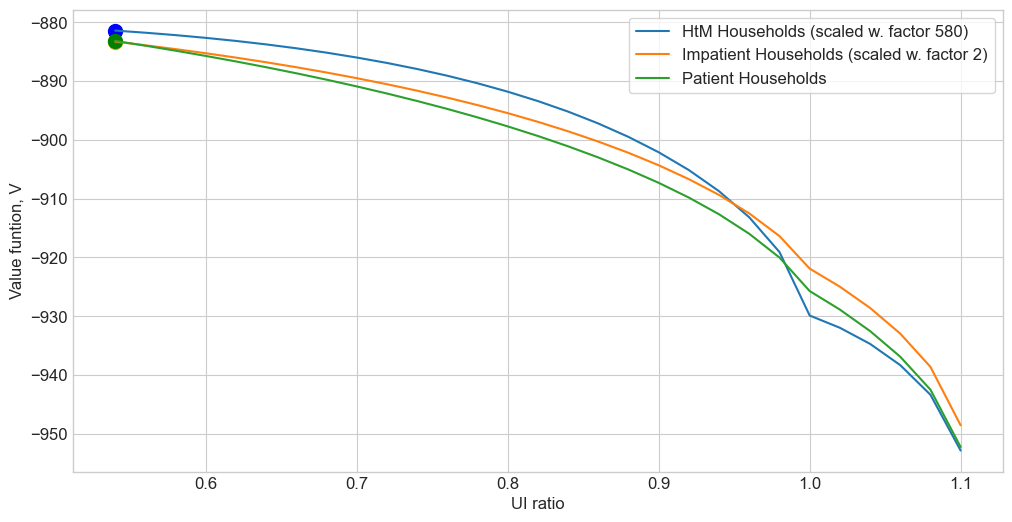

In [11]:
# Depict value functions

fig = plt.figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec, V_UI[:,0]*580, label = f'HtM Households (scaled w. factor 580)' )
ax.plot(UI_ratio_vec, V_UI[:,1]*2, label = f'Impatient Households (scaled w. factor 2)')
ax.plot(UI_ratio_vec, V_UI[:,2], label = f'Patient Households')

ax.scatter(UI_ratio_vec[np.argmax(V_UI[:26,0])],V_UI[:,0][np.argmax(V_UI[:26,0])]*580, color='blue', s = 100)
ax.scatter(UI_ratio_vec[np.argmax(V_UI[:26,1])],V_UI[:,1][np.argmax(V_UI[:26,1])]*2, color='orange', s = 100)
ax.scatter(UI_ratio_vec[np.argmax(V_UI[:26,2])],V_UI[:,2][np.argmax(V_UI[:26,2])], color='green', s = 100)


ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value funtion, V')

Text(0, 0.5, 'Fraction of population')

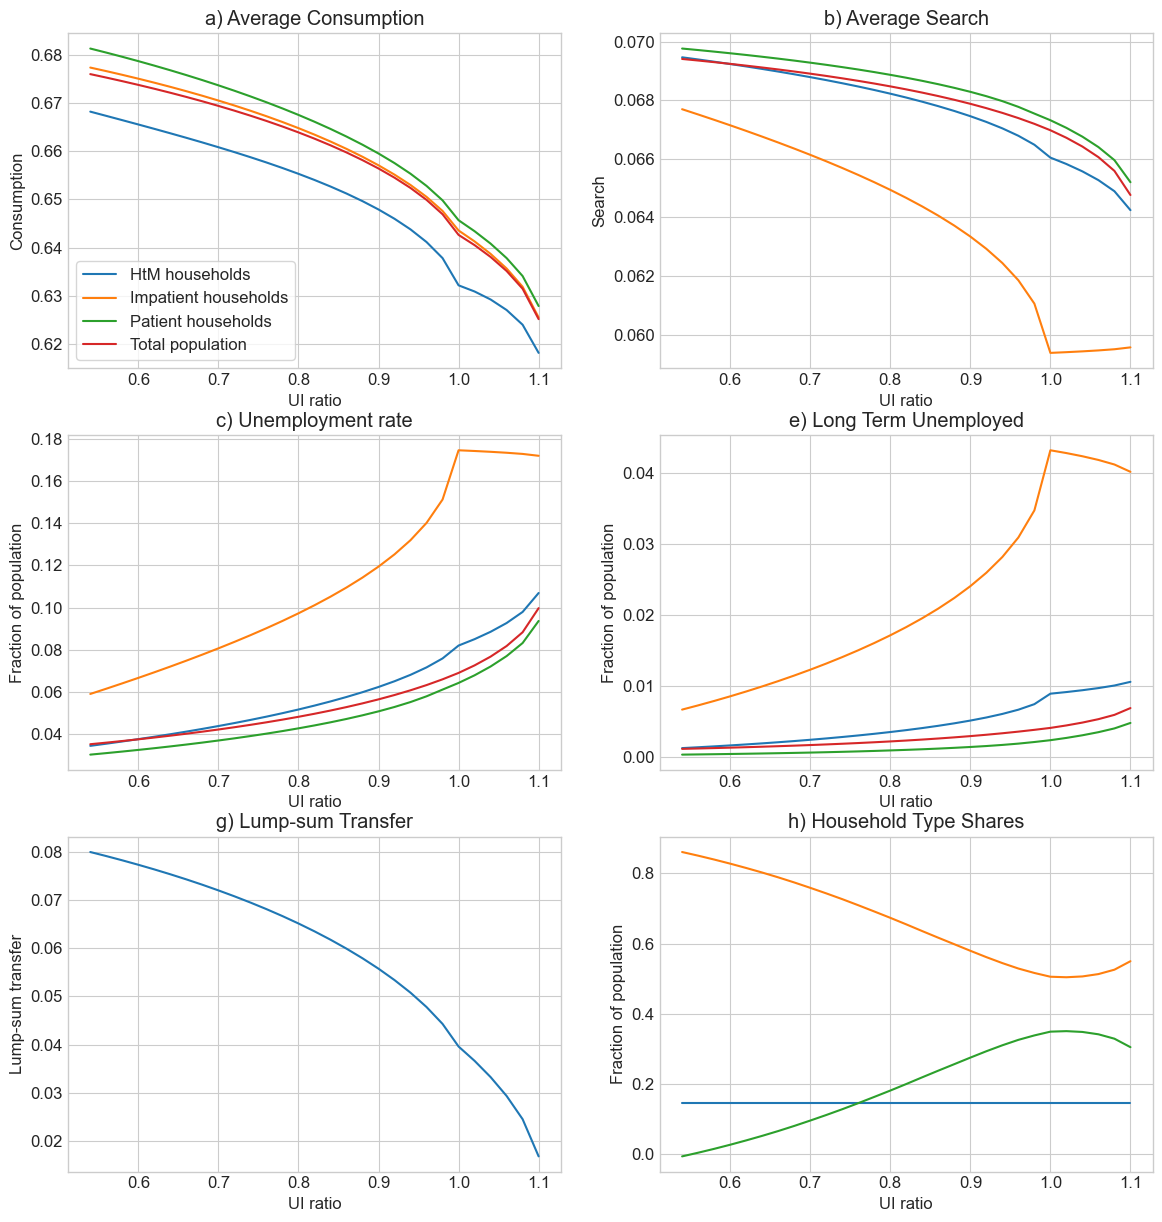

In [13]:
# Depict aggregates

fig = plt.figure(figsize=(14,20),dpi=100)

r = 4

# a. Aggregate Consumption
ax = fig.add_subplot(r,2,1)
ax.set_title(f'a) Average Consumption')

ax.plot(UI_ratio_vec, c_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, c_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, c_pat_UI, label = f'Patient households')
ax.plot(UI_ratio_vec, C_UI, label = f'Total population')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(r,2,2)
ax.set_title(f'b) Average Search')

ax.plot(UI_ratio_vec, S_UI, label = f'Total population')
ax.plot(UI_ratio_vec, s_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, s_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, s_pat_UI, label = f'Patient households')

ax.set_xlabel('UI ratio')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(r,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(UI_ratio_vec, u_UI, label = f'Total population')
ax.plot(UI_ratio_vec, u_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, u_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, u_pat_UI, label = f'Patient households')

ax.set_xlabel('UI ratio')
ax.set_ylabel('Fraction of population')

# e. Long-term unemployed
ax = fig.add_subplot(r,2,4)
ax.set_title(f'e) Long Term Unemployed')

ax.plot(UI_ratio_vec, u_UI - u_UI_UI, label = f'Total population')
ax.plot(UI_ratio_vec, u_htm_UI - u_UI_htm_UI, label = f'HtM households')
ax.plot(UI_ratio_vec, u_im_UI - u_UI_im_UI, label = f'Impatient households')
ax.plot(UI_ratio_vec, u_pat_UI - u_UI_pat_UI, label = f'Patient households')

ax.set_xlabel('UI ratio')
ax.set_ylabel('Fraction of population')

# g. Lump-sum Transfers
ax = fig.add_subplot(r,2,5)
ax.set_title(f'g) Lump-sum Transfer')

ax.plot(UI_ratio_vec, L_UI)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Lump-sum transfer')

# h. Type fractions
ax = fig.add_subplot(r,2,6)
ax.set_title(f'h) Household Type Shares')

ax.plot(UI_ratio_vec, betashare_UI[:,0], label = f'HtM Households')
ax.plot(UI_ratio_vec, betashare_UI[:,1], label = f'Impatient Households')
ax.plot(UI_ratio_vec, betashare_UI[:,2], label = f'Patient Households')
        
ax.set_xlabel('UI ratio')
ax.set_ylabel('Fraction of population')


Text(0, 0.5, 'Ratio')

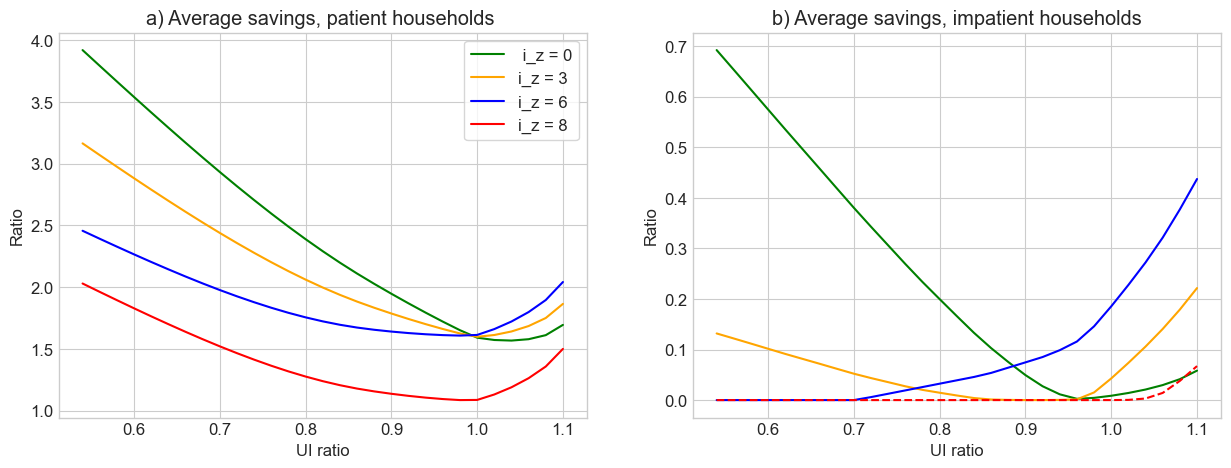

In [18]:
# Depict savings for different unemployment states

g1 = 0
g2 = 3 
g3 = 6
g4 = 8

a0_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a0_im  = np.nan + np.zeros((len(UI_ratio_vec)))

a3_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a3_im = np.nan + np.zeros((len(UI_ratio_vec)))

a6_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a6_im = np.nan + np.zeros((len(UI_ratio_vec)))

a8_pat = np.nan + np.zeros((len(UI_ratio_vec)))
a8_im = np.nan + np.zeros((len(UI_ratio_vec)))

for i in range(len(UI_ratio_vec)):
    a0_pat[i] = np.sum(A_UI_pol[i,2,g1]*D_f[i,2,g1]) / np.sum(D_f[i,2,g1])
    a0_im[i] = np.sum(A_UI_pol[i,1,g1]*D_f[i,1,g1]) / np.sum(D_f[i,1,g1])

    a3_pat[i] = np.sum(A_UI_pol[i,2,g2]*D_f[i,2,g2]) / np.sum(D_f[i,2,g2])
    a3_im[i] = np.sum(A_UI_pol[i,1,g2]*D_f[i,1,g2]) / np.sum(D_f[i,1,g2])

    a6_pat[i] = np.sum(A_UI_pol[i,2,g3]*D_f[i,2,g3]) / np.sum(D_f[i,2,g3])
    a6_im[i] = np.sum(A_UI_pol[i,1,g3]*D_f[i,1,g3]) / np.sum(D_f[i,1,g3])

    a8_pat[i] = np.sum(A_UI_pol[i,2,g4]*D_f[i,2,g4]) / np.sum(D_f[i,2,g4])
    a8_im[i] = np.sum(A_UI_pol[i,1,g4]*D_f[i,1,g4]) / np.sum(D_f[i,1,g4])

    
fig = plt.figure(figsize=(15,5),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(1,2,1)
ax.set_title(f'a) Average savings, patient households ')

ax.plot(UI_ratio_vec, a0_pat, label = f' i_z = {g1}', color = 'green')
ax.plot(UI_ratio_vec, a3_pat, label = f'i_z = {g2}', color = 'orange')
ax.plot(UI_ratio_vec, a6_pat, label = f'i_z = {g3}', color = 'blue')
ax.plot(UI_ratio_vec, a8_pat, label = f'i_z = {g4}', color = 'red')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Ratio')

# b. Aggregate Search
# f. Type fractions
ax = fig.add_subplot(1,2,2)
ax.set_title(f'b) Average savings, impatient households')

ax.plot(UI_ratio_vec, a0_im, label = f'i_z = {g1}, impat. households', color = 'green')
ax.plot(UI_ratio_vec, a3_im, label = f'i_z = {g2}, impat. households', color = 'orange')
ax.plot(UI_ratio_vec, a6_im, label = f'i_z = {g3}, impat. households', color = 'blue')
ax.plot(UI_ratio_vec, a8_im, label = f'i_z = {g4}, impat. households', color = 'red', linestyle = 'dashed' )

ax.set_xlabel('UI ratio')
ax.set_ylabel('Ratio')


In [ ]:
# Depict search for different unemployment states
g1 = 0
g2 = 3 
g3 = 6
g4 = 8

s0_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s0_im  = np.nan + np.zeros((len(UI_ratio_vec)))

s3_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s3_im = np.nan + np.zeros((len(UI_ratio_vec)))

s6_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s6_im = np.nan + np.zeros((len(UI_ratio_vec)))

s8_pat = np.nan + np.zeros((len(UI_ratio_vec)))
s8_im = np.nan + np.zeros((len(UI_ratio_vec)))

for i in range(len(UI_ratio_vec)):
    
    s0_pat[i] = np.sum(S_UI_pol[i,2,g1]*Dbeg_UI[i,2,g1]) * 1/ss.delta / np.sum(D_f[i,2,g1])
    s0_im[i] = np.sum(S_UI_pol[i,1,g1]*Dbeg_UI[i,1,g1]) *1/ss.delta / np.sum(D_f[i,1,g1])

    s3_pat[i] = np.sum(S_UI_pol[i,2,g2]*Dbeg_UI[i,2,g2]) / np.sum(D_f[i,2,g2])
    s3_im[i] = np.sum(S_UI_pol[i,1,g2]*Dbeg_UI[i,1,g2]) / np.sum(D_f[i,1,g2])

    s6_pat[i] = np.sum(S_UI_pol[i,2,g3]*Dbeg_UI[i,2,g3]) / np.sum(D_f[i,2,g3])
    s6_im[i] = np.sum(S_UI_pol[i,1,g3]*Dbeg_UI[i,1,g3]) / np.sum(D_f[i,1,g3])

    s8_pat[i] = np.sum(S_UI_pol[i,2,g4]*Dbeg_UI[i,2,g4]) / np.sum(D_f[i,2,g4])
    s8_im[i] = np.sum(S_UI_pol[i,1,g4]*Dbeg_UI[i,1,g4]) / np.sum(D_f[i,1,g4])


fig = plt.figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec, s0_pat, label = f' i_z = {g1}, pat. households', color = 'blue')
ax.plot(UI_ratio_vec, s0_im, label = f'i_z = {g1}, impat. households', color = 'blue', linestyle = 'dashed' )
                          
ax.plot(UI_ratio_vec, s3_pat, label = f'i_z = {g2}, pat.households', color = 'orange')
ax.plot(UI_ratio_vec, s3_im, label = f'i_z = {g2}, impat. households', color = 'orange', linestyle = 'dashed' )
                          
ax.plot(UI_ratio_vec, s6_pat, label = f'i_z = {g3}, pat. households', color = 'green')
ax.plot(UI_ratio_vec, s6_im, label = f'i_z = {g3}, impat. households', color = 'green', linestyle = 'dashed' )

ax.plot(UI_ratio_vec, s8_pat, label = f'i_z = {g4}, pat. households', color = 'red')
ax.plot(UI_ratio_vec, s8_im, label = f'i_z = {g4}, impat. households', color = 'red', linestyle = 'dashed' )
ax.legend(frameon = True) 

ax.set_xlabel('UI ratio')
ax.set_ylabel('Average search intensity')

In [ ]:
# Depict unemployment rates for each unemployment relative to the total unemployment rate

fig = plt.figure(figsize=(10,5),dpi=100)

# a. Aggregate Consumption
ax = fig.add_subplot(1,2,1)
ax.set_title(f'a) Total unemployment ')

ax.plot(UI_ratio_vec, frac_htm_UI / u_UI, label = f'HtM Households')
ax.plot(UI_ratio_vec, frac_im_UI / u_UI, label = f'Impatient Households')
ax.plot(UI_ratio_vec, frac_pat_UI / u_UI , label = f'Patient Households')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Ratio')

# b. Aggregate Search
# f. Type fractions
ax = fig.add_subplot(1,2,2)
ax.set_title(f'b) Long-term unemployment')

ax.plot(UI_ratio_vec, fracl_htm_UI / (u_UI - u_UI_UI), label = f'HtM Households')
ax.plot(UI_ratio_vec, fracl_im_UI / (u_UI - u_UI_UI), label = f'Impatient Households')
ax.plot(UI_ratio_vec, fracl_pat_UI / (u_UI -u_UI_UI) , label = f'Patient Households')
        
ax.set_xlabel('UI ratio')
ax.set_ylabel('Ratio')

## Percentiles

In [131]:
# Calculate value functions at percentiles

# a. make sure that distribution only containins elements > 0
for k in range(len(UI_ratio_vec)):
    if np.min(D_f[k]) > 0 and np.min(D_f[k-1]) < 0:
        break
    elif np.min(D_f[k]) == 0 and np.min(D_f[k-1]) < 0:
        break
    else:
        k = 0

shape = par.Nz*par.Na
UI_rat_vec_f = UI_ratio_vec[k:]

perc_vec = [0.01, 0.02, 0.04, 0.06]

# Initialize
cum_f_pat = np.nan + np.zeros((len(UI_rat_vec_f), shape))
V_f_pat = np.nan + np.zeros((len(UI_rat_vec_f), shape))
cum_f_im = np.nan + np.zeros((len(UI_rat_vec_f), shape))
V_f_im = np.nan + np.zeros((len(UI_rat_vec_f), shape))
cum_f_htm = np.nan + np.zeros((len(UI_rat_vec_f), shape))
V_f_htm = np.nan + np.zeros((len(UI_rat_vec_f), shape))

U_goal_pat = np.nan + np.zeros((len(UI_rat_vec_f), len(perc_vec)))
U_goal_im = np.nan + np.zeros((len(UI_rat_vec_f), len(perc_vec)))
U_goal_htm = np.nan + np.zeros((len(UI_rat_vec_f), len(perc_vec)))

# Calculate percentiles
for i in range(len(UI_rat_vec_f[k:])):
    mat_V = V_f[i+k]
    mat_D = D_f[i+k]
    
    V_f_pat[i], cum_f_pat[i], V_f_im[i], cum_f_im[i],  V_f_htm[i], cum_f_htm[i]  = get_cum_dist(mat_V, mat_D)
    
    for j in range(len(perc_vec)):
        U_goal_pat[i,j], U_goal_im[i,j], U_goal_htm[i,j] = get_perc(V_f_pat[i], cum_f_pat[i], V_f_im[i], cum_f_im[i],  V_f_htm[i], cum_f_htm[i], perc_vec[j])

Text(0, 0.5, 'Value function')

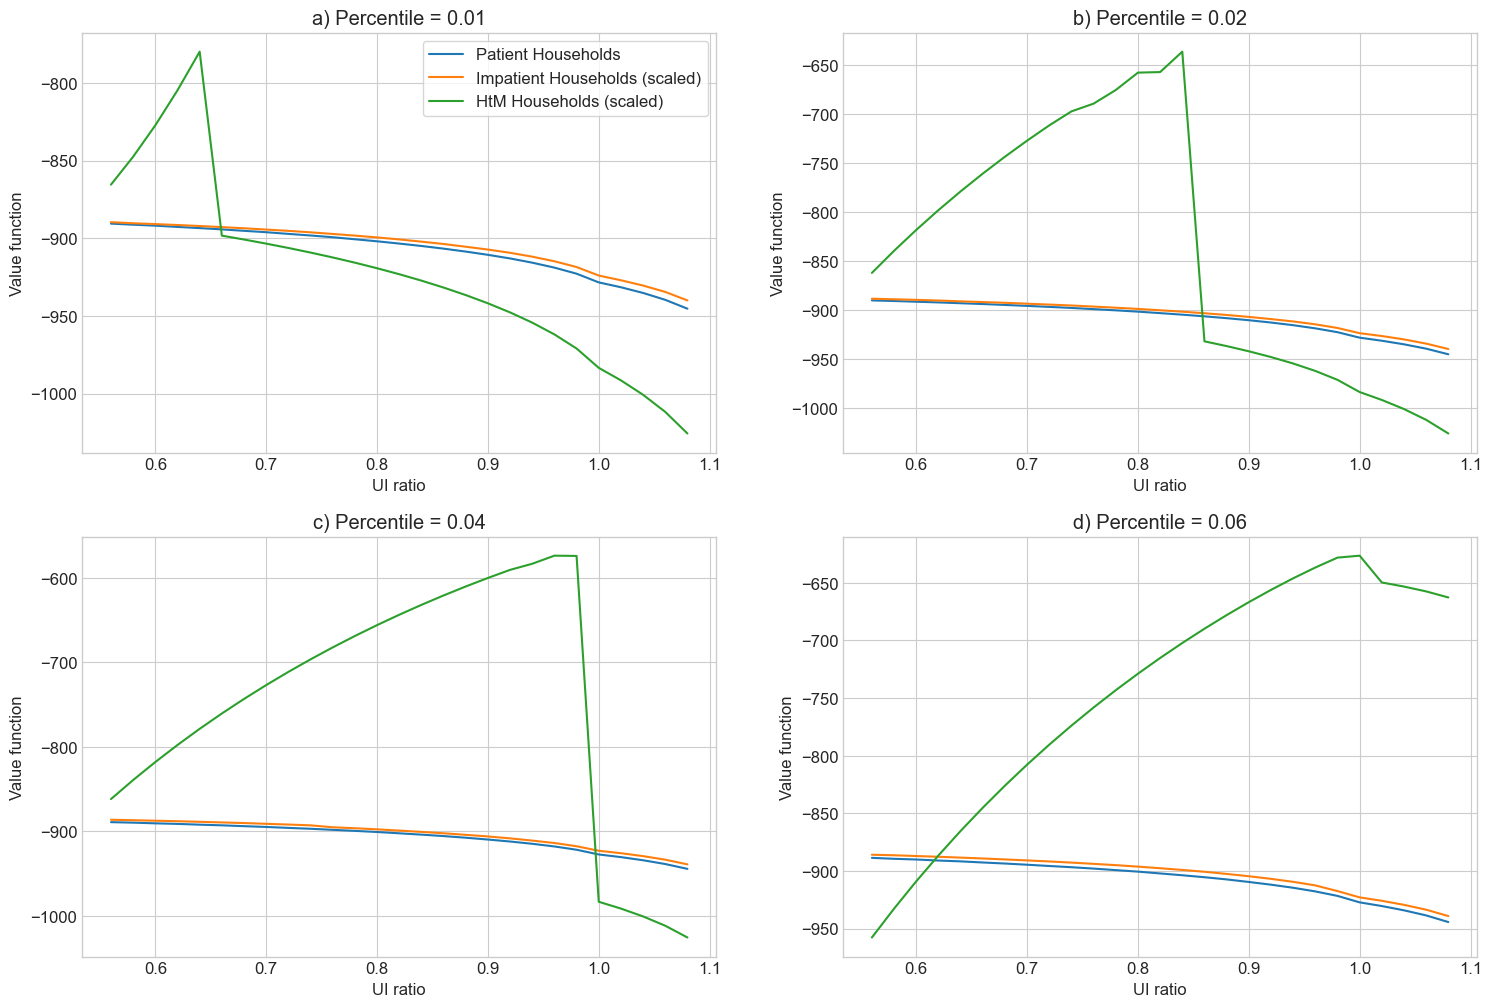

In [132]:
#Depict percentiles
fig = plt.figure(figsize=(18,12),dpi=100)


ax = fig.add_subplot(2,2,1)
ax.set_title(f'a) Percentile = {perc_vec[0]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,0], label = 'Patient Households')
ax.plot(UI_rat_vec_f, U_goal_im[:,0]*2, label = 'Impatient Households (scaled)')
ax.plot(UI_rat_vec_f, U_goal_htm[:,0]*360, label = 'HtM Households (scaled)')

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,0])],U_goal_pat[:,0][np.argmax(U_goal_pat[:,0])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,0])],U_goal_im[:,0][np.argmax(U_goal_im[:,0])]*2, color='orange', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,0])],U_goal_htm[:,0][np.argmax(U_goal_htm[:,0])]*350, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')

ax.legend(frameon=True)

ax = fig.add_subplot(2,2,2)
ax.set_title(f'b) Percentile = {perc_vec[1]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,1])
ax.plot(UI_rat_vec_f, U_goal_im[:,1]*2)
ax.plot(UI_rat_vec_f, U_goal_htm[:,1]*360)

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,1])],U_goal_pat[:,1][np.argmax(U_goal_pat[:,1])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,1])],U_goal_im[:,1][np.argmax(U_goal_im[:,1])]*2, color='orange', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,1])],U_goal_htm[:,1][np.argmax(U_goal_htm[:,1])]*400, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')

ax = fig.add_subplot(2,2,3)
ax.set_title(f'c) Percentile = {perc_vec[2]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,2])
ax.plot(UI_rat_vec_f, U_goal_im[:,2]*2)
ax.plot(UI_rat_vec_f, U_goal_htm[:,2]*360)

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,2])],U_goal_pat[:,2][np.argmax(U_goal_pat[:,2])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,2])],U_goal_im[:,2][np.argmax(U_goal_im[:,2])]*2, color='orange', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,2])],U_goal_htm[:,2][np.argmax(U_goal_htm[:,2])]*400, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')

ax = fig.add_subplot(2,2,4)
ax.set_title(f'd) Percentile = {perc_vec[3]}')

ax.plot(UI_rat_vec_f, U_goal_pat[:,3])
ax.plot(UI_rat_vec_f, U_goal_im[:,3]*2)
ax.plot(UI_rat_vec_f, U_goal_htm[:,3]*400)

ax.scatter(UI_rat_vec_f[np.argmax(U_goal_pat[:,3])],U_goal_pat[:,3][np.argmax(U_goal_pat[:,3])], color='blue', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_im[:,3])],U_goal_im[:,3][np.argmax(U_goal_im[:,3])]*2, color='orange', s = 100)
ax.scatter(UI_rat_vec_f[np.argmax(U_goal_htm[:,3])],U_goal_htm[:,3][np.argmax(U_goal_htm[:,3])]*550, color='green', s = 100)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value function')


## Gini Coefficients

Text(0, 0.5, 'Gini Coefficient')

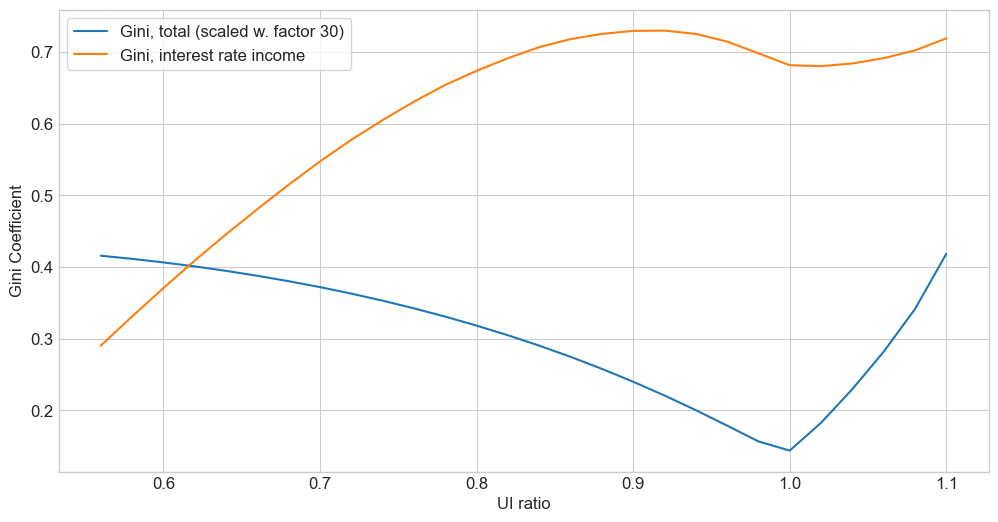

In [21]:
# Depict Gini coeffients

# Make sure distribution only contains elements > 0
for i in range(len(UI_ratio_vec)):
    if gini_UI[i] > 0 and gini_UI[i-1] == 0:
        break
    else:
        i = 0

fig = plt.figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec[i:], gini_UI[i:]*30, label = 'Gini, total (scaled w. factor 30)')
ax.plot(UI_ratio_vec[i:], gini_r_UI[i:], label = 'Gini, interest rate income')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Gini Coefficient')

# Optimal UI Duration in The Steady State

In [43]:
# Caluclate ss for different UI durations

par.UI_ratio_high = 0.83

par.exo_search = False
par.varphi = 0.5

UI_dur_vec = np.linspace(0.0, 13.0, 14)

# Search
S_UId = np.nan + np.zeros(len(UI_dur_vec))
s_htm_UId = np.nan + np.zeros(len(UI_dur_vec))
s_im_UId = np.nan + np.zeros(len(UI_dur_vec))
s_pat_UId = np.nan + np.zeros(len(UI_dur_vec))

#savings 
A_UId = np.nan + np.zeros((len(UI_dur_vec), par.Nfix, par.Nz, par.Na))

a_im_UId = np.nan + np.zeros(len(UI_dur_vec))
a_pat_UId = np.nan + np.zeros(len(UI_dur_vec))

# Consumption
C_UId = np.nan + np.zeros(len(UI_dur_vec))
c_htm_UId = np.nan + np.zeros(len(UI_dur_vec))
c_im_UId = np.nan + np.zeros(len(UI_dur_vec))
c_pat_UId = np.nan + np.zeros(len(UI_dur_vec))

# Unemployment rates
u_UId = np.nan + np.zeros(len(UI_dur_vec))
u_htm_UId = np.nan + np.zeros(len(UI_dur_vec))
u_im_UId = np.nan + np.zeros(len(UI_dur_vec))
u_pat_UId = np.nan + np.zeros(len(UI_dur_vec))
    
# Long term unemployed
u_UI_UId = np.nan + np.zeros(len(UI_dur_vec))
u_UI_htm_UId = np.nan + np.zeros(len(UI_dur_vec))
u_UI_im_UId = np.nan + np.zeros(len(UI_dur_vec))
u_UI_pat_UId = np.nan + np.zeros(len(UI_dur_vec))

#ut unemployed
ut_UId = np.nan + np.zeros(len(UI_dur_vec))
ut_htm_UId = np.nan + np.zeros(len(UI_dur_vec))
ut_im_UId = np.nan + np.zeros(len(UI_dur_vec))
ut_pat_UId = np.nan + np.zeros(len(UI_dur_vec))

#Unemployment fractions
frac_htm_UId = np.nan + np.zeros(len(UI_dur_vec))
frac_im_UId = np.nan + np.zeros(len(UI_dur_vec))
frac_pat_UId = np.nan + np.zeros(len(UI_dur_vec))

fracl_htm_UId = np.nan + np.zeros(len(UI_dur_vec))
fracl_im_UId = np.nan + np.zeros(len(UI_dur_vec))
fracl_pat_UId = np.nan + np.zeros(len(UI_dur_vec))

# Other aggregates
betashare_UId = np.nan + np.zeros((len(UI_dur_vec), len(par.beta_grid)))
V_UId = np.nan + np.zeros((len(UI_dur_vec), len(par.beta_grid)))
L_UId = np.nan + np.zeros(len(UI_dur_vec))
lambda_u_UId = np.nan + np.zeros(len(UI_dur_vec))

# for fractiles
D_fd = np.nan + np.zeros((len(UI_dur_vec), par.Nfix, par.Nz, par.Na))
V_fd = np.nan + np.zeros((len(UI_dur_vec), par.Nfix, par.Nz, par.Na))
Dbeg_UId = np.nan + np.zeros((len(UI_dur_vec), par.Nfix, par.Nz, par.Na))

# Gini
gini_UId = np.nan + np.zeros(len(UI_dur_vec))
gini_r_UId = np.nan + np.zeros(len(UI_dur_vec))


for i in range(len(UI_dur_vec)):
    par.UI_duration = UI_dur_vec[i]
    print(par.UI_duration)
    model.find_ss()
    
    # Search
    S_UId[i] = ss.S
    
    Dbeg_UId[i] = ss.Dbeg
    
    s_htm_UId[i] = np.sum(ss.s[0]*ss.Dbeg[0]) / np.sum(ss.Dbeg[0])
    s_im_UId[i] = np.sum(ss.s[1]*ss.Dbeg[1]) / np.sum(ss.Dbeg[1])
    s_pat_UId[i] = np.sum(ss.s[2]*ss.Dbeg[2]) / np.sum(ss.Dbeg[2])
    
    #savings 
    A_UId[i] = ss.a
    
    a_im_UId[i] = np.sum(ss.a[1]*ss.D[1]) / np.sum(ss.D[1])
    a_pat_UId[i] = np.sum(ss.a[2]*ss.D[2]) / np.sum(ss.D[2])
    
    
    # Consumption
    C_UId[i] = ss.C_hh
    
    c_htm_UId[i] = np.sum(ss.c[0]*ss.D[0]) / np.sum(ss.D[0])
    c_im_UId[i] = np.sum(ss.c[1]*ss.D[1]) / np.sum(ss.D[1])
    c_pat_UId[i] = np.sum(ss.c[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # unemployment rates
    u_UId[i] = ss.u
    
    u_htm_UId[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    u_im_UId[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    u_pat_UId[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])
    
    # Long term unemployed
    u_UI_UId[i] = ss.U_UI_hh
    
    u_UI_htm_UId[i] = np.sum(ss.u_UI[0]*ss.D[0]) / np.sum(ss.D[0])
    u_UI_im_UId[i] = np.sum(ss.u_UI[1]*ss.D[1]) / np.sum(ss.D[1])
    u_UI_pat_UId[i] = np.sum(ss.u_UI[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #ut unemployed
    ut_UId[i] = ss.ut
    
    ut_htm_UId[i] = (ss.delta*np.sum(ss.D[0,0]) + np.sum(ss.D[0,1:]))  / np.sum(ss.D[0])
    ut_im_UId[i] = (ss.delta*np.sum(ss.D[1,0]) + np.sum(ss.D[1,1:])) / np.sum(ss.D[1])
    ut_pat_UId[i] = (ss.delta*np.sum(ss.D[2,0]) + np.sum(ss.D[2,1:])) / np.sum(ss.D[2])
    
    #Fractions of total unemployment
    frac_htm_UId[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    frac_im_UId[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    frac_pat_UId[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])

    fracl_htm_UId[i] = np.sum(ss.D[0,7:]) / np.sum(ss.D[0])
    fracl_im_UId[i] = np.sum(ss.D[1,7:]) / np.sum(ss.D[1])
    fracl_pat_UId[i] = np.sum(ss.D[2,7:]) / np.sum(ss.D[2])
    
    #Other aggregates
    L_UId[i] = ss.L
    betashare_UId[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    V_UId[i] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]  
    lambda_u_UId[i] = ss.lambda_u
    
    # For fractiles
    V_fd[i] = ss.V
    D_fd[i] = ss.D
    
    # For gini
    if np.min(ss.D) < 0:
        gini_UId[i] = 0.0
    else:
        _, _, gini_UId[i] = gini(ss,par)
        _, _, gini_r_UId[i] = gini_r(ss,par)

    

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0


Text(0, 0.5, 'Value funtion, V')

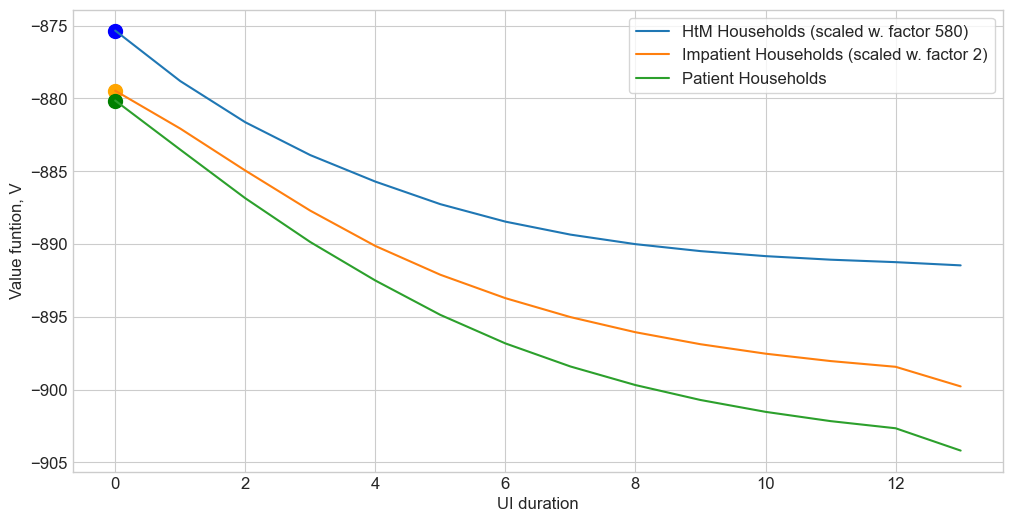

In [44]:
# Depict value functions

fig = plt.figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_dur_vec, V_UId[:14,0]*580, label = f'HtM Households (scaled w. factor 580)')
ax.plot(UI_dur_vec, V_UId[:14,1]*2, label = f'Impatient Households (scaled w. factor 2)')
ax.plot(UI_dur_vec, V_UId[:14,2], label = f'Patient Households')

ax.scatter(UI_dur_vec[np.argmax(V_UId[:14,0])],V_UId[:14,0][np.argmax(V_UId[:14,0])]*580, color='blue', s = 100)
ax.scatter(UI_dur_vec[np.argmax(V_UId[:14,1])],V_UId[:14,1][np.argmax(V_UId[:14,1])]*2, color='orange', s = 100)
ax.scatter(UI_dur_vec[np.argmax(V_UId[:14,2])],V_UId[:14,2][np.argmax(V_UId[:14,2])], color='green', s = 100)


ax.legend(frameon = True)

ax.set_xlabel('UI duration')
ax.set_ylabel('Value funtion, V')

Text(0, 0.5, 'Fraction of population')

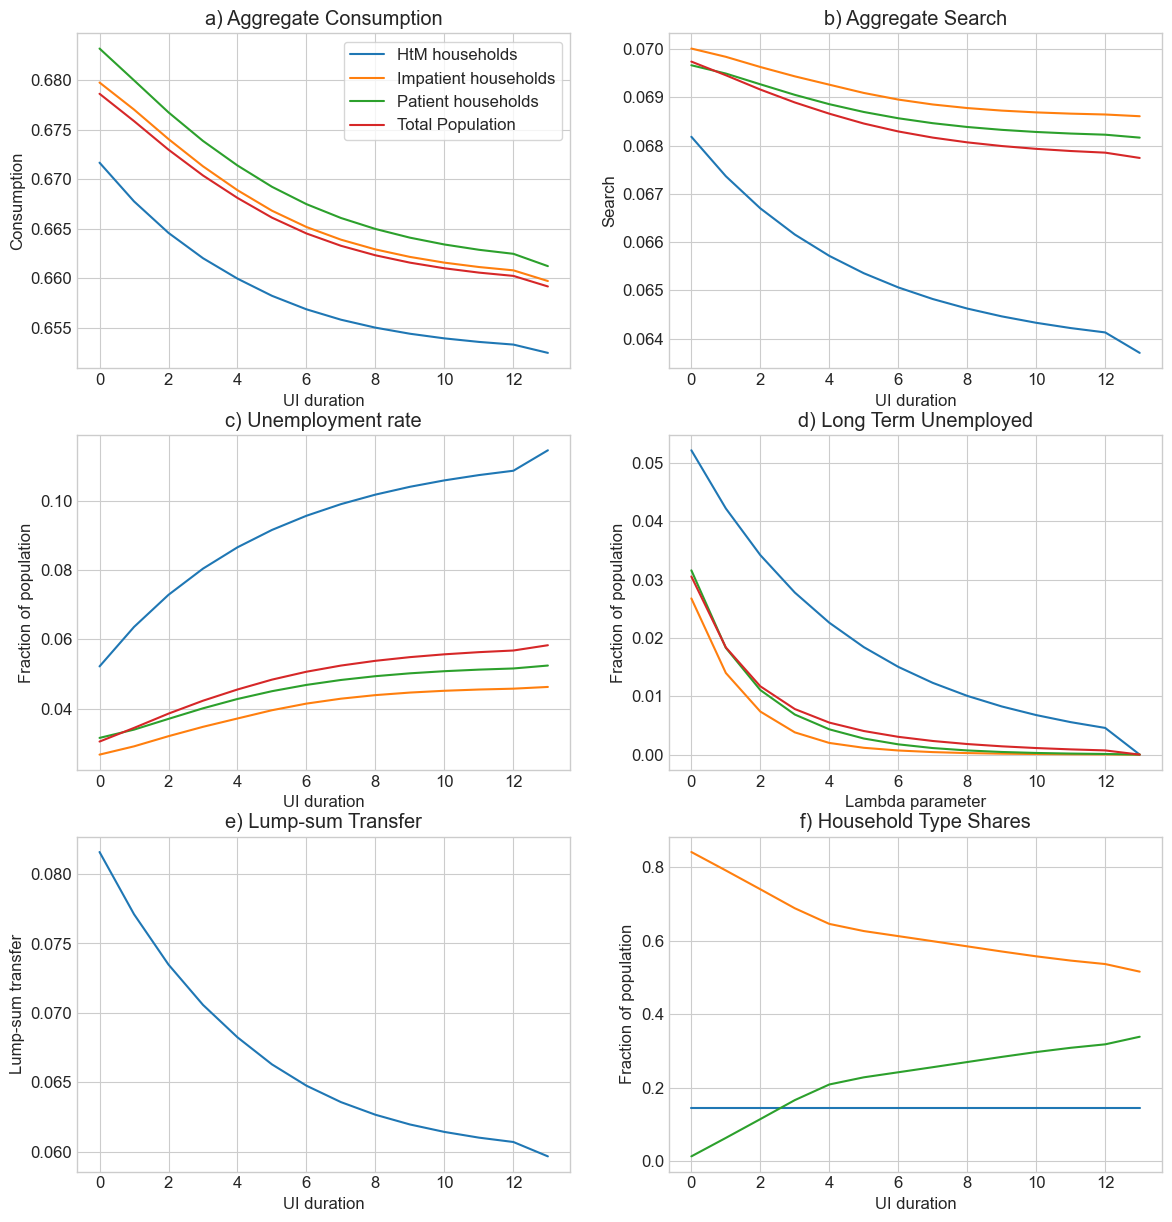

In [50]:
# Depict aggregates

fig = plt.figure(figsize=(14,20),dpi=100)

r = 4

# a. Aggregate Consumption
ax = fig.add_subplot(r,2,1)
ax.set_title(f'a) Aggregate Consumption')

ax.plot(UI_dur_vec, c_htm_UId, label = f'HtM households')
ax.plot(UI_dur_vec, c_im_UId, label = f'Impatient households')
ax.plot(UI_dur_vec, c_pat_UId, label = f'Patient households')
ax.plot(UI_dur_vec, C_UId, label = f'Total Population')

ax.legend(frameon = True)

ax.set_xlabel('UI duration')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(r,2,2)
ax.set_title(f'b) Aggregate Search')

ax.plot(UI_dur_vec, s_htm_UId, label = f'HtM households')
ax.plot(UI_dur_vec, s_im_UId, label = f'Impatient households')
ax.plot(UI_dur_vec, s_pat_UId, label = f'Patient households')
ax.plot(UI_dur_vec, S_UId, label = f'Total Population')


ax.set_xlabel('UI duration')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(r,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(UI_dur_vec, u_htm_UId, label = f'HtM households')
ax.plot(UI_dur_vec, u_im_UId, label = f'Impatient households')
ax.plot(UI_dur_vec, u_pat_UId, label = f'Patient households')
ax.plot(UI_dur_vec, u_UId)


ax.set_xlabel('UI duration')
ax.set_ylabel('Fraction of population')

# e. Long-term unemployed
ax = fig.add_subplot(r,2,4)
ax.set_title(f'd) Long Term Unemployed')

ax.plot(UI_dur_vec, u_htm_UId - u_UI_htm_UId, label = f'HtM households')
ax.plot(UI_dur_vec, u_im_UId - u_UI_im_UId, label = f'Impatient households')
ax.plot(UI_dur_vec, u_pat_UId - u_UI_pat_UId, label = f'Patient households')
ax.plot(UI_dur_vec, u_UId - u_UI_UId)


ax.set_xlabel('UI duration')
ax.set_ylabel('Fraction of population')


ax.set_xlabel('Lambda parameter')
ax.set_ylabel('Fraction of population')

# g. Lump-sum Transfers
ax = fig.add_subplot(r,2,5)
ax.set_title(f'e) Lump-sum Transfer')

ax.plot(UI_dur_vec, L_UId)

ax.set_xlabel('UI duration')
ax.set_ylabel('Lump-sum transfer')

# h. Type fractions
ax = fig.add_subplot(r,2,6)
ax.set_title(f'f) Household Type Shares')

ax.plot(UI_dur_vec, betashare_UId[:,0], label = f'HtM Households')
ax.plot(UI_dur_vec, betashare_UId[:,1], label = f'Impatient Households')
ax.plot(UI_dur_vec, betashare_UId[:,2], label = f'Patient Households')

        
ax.set_xlabel('UI duration')
ax.set_ylabel('Fraction of population')

## Percentiles

In [128]:
# Calculate percentiles

shape = par.Nz*par.Na

perc_vec = [0.01, 0.02, 0.04, 0.06]

cum_fd_pat = np.nan + np.zeros((len(UI_dur_vec), shape))
V_fd_pat = np.nan + np.zeros((len(UI_dur_vec), shape))
cum_fd_im = np.nan + np.zeros((len(UI_dur_vec), shape))
V_fd_im = np.nan + np.zeros((len(UI_dur_vec), shape))
cum_fd_htm = np.nan + np.zeros((len(UI_dur_vec), shape))
V_fd_htm = np.nan + np.zeros((len(UI_dur_vec), shape))

U_goal_patd = np.nan + np.zeros((len(UI_dur_vec), len(perc_vec)))
U_goal_imd = np.nan + np.zeros((len(UI_dur_vec), len(perc_vec)))
U_goal_htmd = np.nan + np.zeros((len(UI_dur_vec), len(perc_vec)))

for i in range(len(UI_dur_vec)):
    mat_Vd = V_fd[i]
    mat_Dd = D_fd[i]
    
    V_fd_pat[i], cum_fd_pat[i], V_fd_im[i], cum_fd_im[i],  V_fd_htm[i], cum_fd_htm[i]  = get_cum_dist(mat_Vd, mat_Dd)
    
    for j in range(len(perc_vec)):
        U_goal_patd[i,j], U_goal_imd[i,j], U_goal_htmd[i,j] = get_perc(V_fd_pat[i], cum_fd_pat[i], V_fd_im[i], cum_fd_im[i],  V_fd_htm[i], cum_fd_htm[i], perc_vec[j])

Text(0, 0.5, 'Value function')

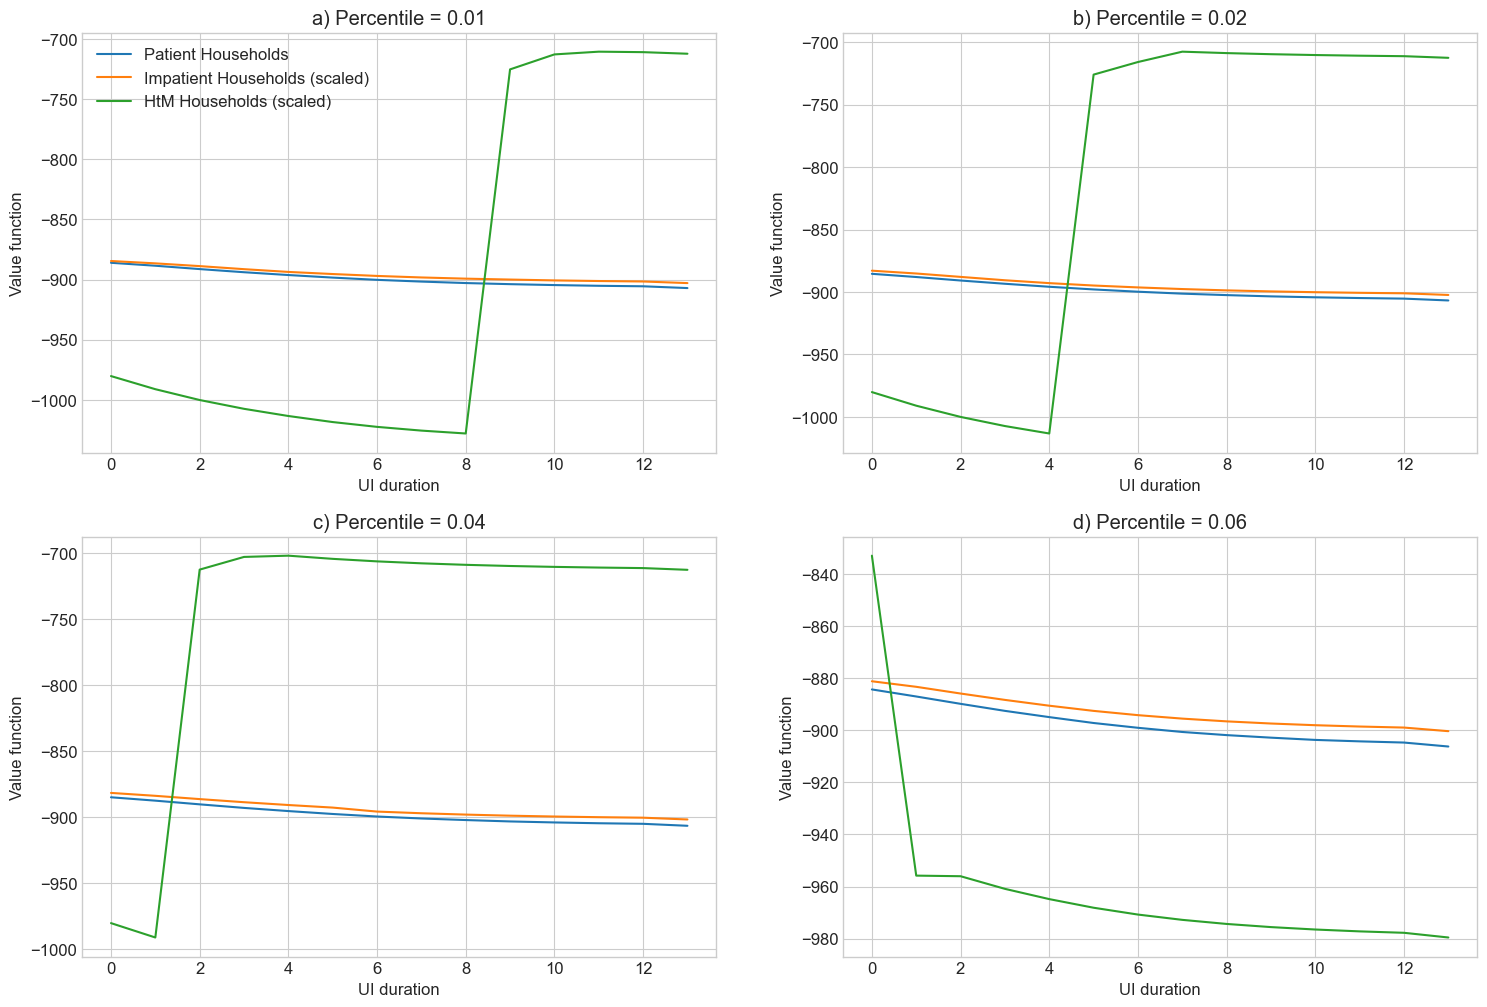

In [129]:
# Depict percentiles

fig = plt.figure(figsize=(18,12),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.set_title(f'a) Percentile = {perc_vec[0]}')

ax.plot(UI_dur_vec, U_goal_patd[:,0], label = 'Patient Households')
ax.plot(UI_dur_vec, U_goal_imd[:,0]*2, label = 'Impatient Households (scaled)')
ax.plot(UI_dur_vec, U_goal_htmd[:,0]*400, label = 'HtM Households (scaled)')



ax.set_xlabel('UI duration')
ax.set_ylabel('Value function')

ax.legend()

ax = fig.add_subplot(2,2,2)
ax.set_title(f'b) Percentile = {perc_vec[1]}')

ax.plot(UI_dur_vec, U_goal_patd[:,1])
ax.plot(UI_dur_vec, U_goal_imd[:,1]*2)
ax.plot(UI_dur_vec, U_goal_htmd[:,1]*400)



ax.set_xlabel('UI duration')
ax.set_ylabel('Value function')

ax = fig.add_subplot(2,2,3)
ax.set_title(f'c) Percentile = {perc_vec[2]}')

ax.plot(UI_dur_vec, U_goal_patd[:,2])
ax.plot(UI_dur_vec, U_goal_imd[:,2]*2)
ax.plot(UI_dur_vec, U_goal_htmd[:,2]*400)



ax.set_xlabel('UI duration')
ax.set_ylabel('Value function')

ax = fig.add_subplot(2,2,4)
ax.set_title(f'd) Percentile = {perc_vec[3]}')

ax.plot(UI_dur_vec, U_goal_patd[:,3])
ax.plot(UI_dur_vec, U_goal_imd[:,3]*2)
ax.plot(UI_dur_vec, U_goal_htmd[:,3]*550)



ax.set_xlabel('UI duration')
ax.set_ylabel('Value function')


## Gini Coefficients

Text(0, 0.5, 'Gini Coefficient')

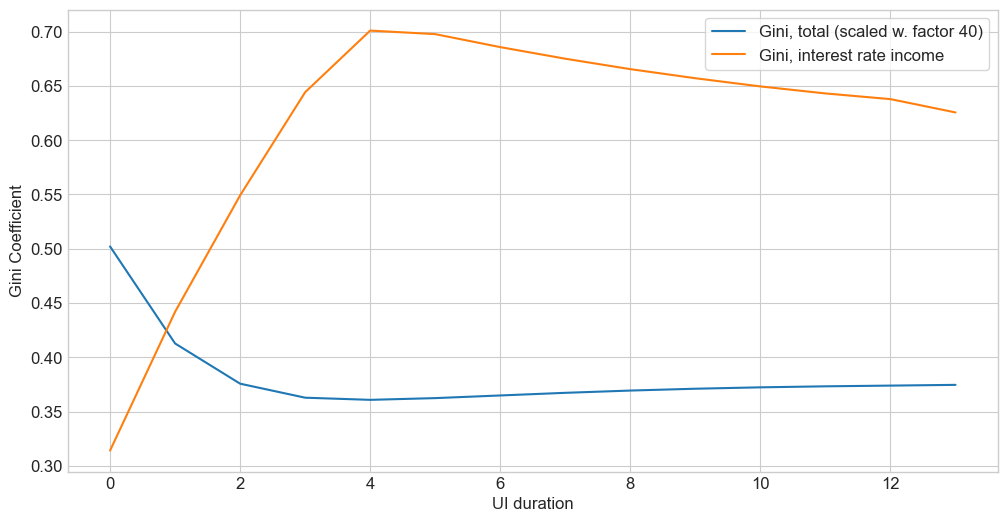

In [33]:
# Depict Gini
fig = plt.figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_dur_vec, gini_UId*40, label = 'Gini, total (scaled w. factor 40)')
ax.plot(UI_dur_vec, gini_r_UId, label = 'Gini, interest rate income')

ax.legend(frameon = True)
ax.set_xlabel('UI duration')
ax.set_ylabel('Gini Coefficient')


# Changing both the UI duration and the UI ratio

## For Value Functions

In [10]:
#Calculate

UI_ratio_vectot = np.linspace(0.54,1.1,29) 
UI_dur_vectot = np.linspace(0.0,8.0,9)

# Aggregate value function
V_tot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot), len(par.beta_grid)))

# For fractiles
V_ftot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot), par.Nfix, par.Nz, par.Na))
D_ftot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot), par.Nfix, par.Nz, par.Na))

# For gini
gini_tot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot)))


for i in range(len(UI_dur_vectot)):
    for j in range(len(UI_ratio_vectot)):
        par.UI_duration = UI_dur_vectot[i]
        par.UI_ratio_high = UI_ratio_vectot[j]
        
        print(par.UI_duration)
        print(par.UI_ratio_high)
        
        model.find_ss()
        
        #Value function
        V_tot[i,j] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]  
    
        # For fractiles
        V_ftot[i,j] = ss.V
        D_ftot[i,j] = ss.D
    
        # Gini
        if np.min(ss.D) < 0:
            gini_tot[i,j] = 0.0
        else:
            _, _, gini_tot[i,j] = gini(ss,par)

0.0
0.54
0.0
0.56
0.0
0.5800000000000001
0.0
0.6000000000000001
0.0
0.62
0.0
0.64
0.0
0.66
0.0
0.68
0.0
0.7000000000000001
0.0
0.72
0.0
0.74
0.0
0.76
0.0
0.78
0.0
0.8
0.0
0.8200000000000001
0.0
0.8400000000000001
0.0
0.8600000000000001
0.0
0.8800000000000001
0.0
0.9
0.0
0.92
0.0
0.9400000000000001
0.0
0.96
0.0
0.98
0.0
1.0
0.0
1.02
0.0
1.04
0.0
1.06
0.0
1.08
0.0
1.1
1.0
0.54
1.0
0.56
1.0
0.5800000000000001
1.0
0.6000000000000001
1.0
0.62
1.0
0.64
1.0
0.66
1.0
0.68
1.0
0.7000000000000001
1.0
0.72
1.0
0.74
1.0
0.76
1.0
0.78
1.0
0.8
1.0
0.8200000000000001
1.0
0.8400000000000001
1.0
0.8600000000000001
1.0
0.8800000000000001
1.0
0.9
1.0
0.92
1.0
0.9400000000000001
1.0
0.96
1.0
0.98
1.0
1.0
1.0
1.02
1.0
1.04
1.0
1.06
1.0
1.08
1.0
1.1
2.0
0.54
2.0
0.56
2.0
0.5800000000000001
2.0
0.6000000000000001
2.0
0.62
2.0
0.64
2.0
0.66
2.0
0.68
2.0
0.7000000000000001
2.0
0.72
2.0
0.74
2.0
0.76
2.0
0.78
2.0
0.8
2.0
0.8200000000000001
2.0
0.8400000000000001
2.0
0.8600000000000001
2.0
0.8800000000000001
2.0

Text(0.5, 0.5, 'UI duration')

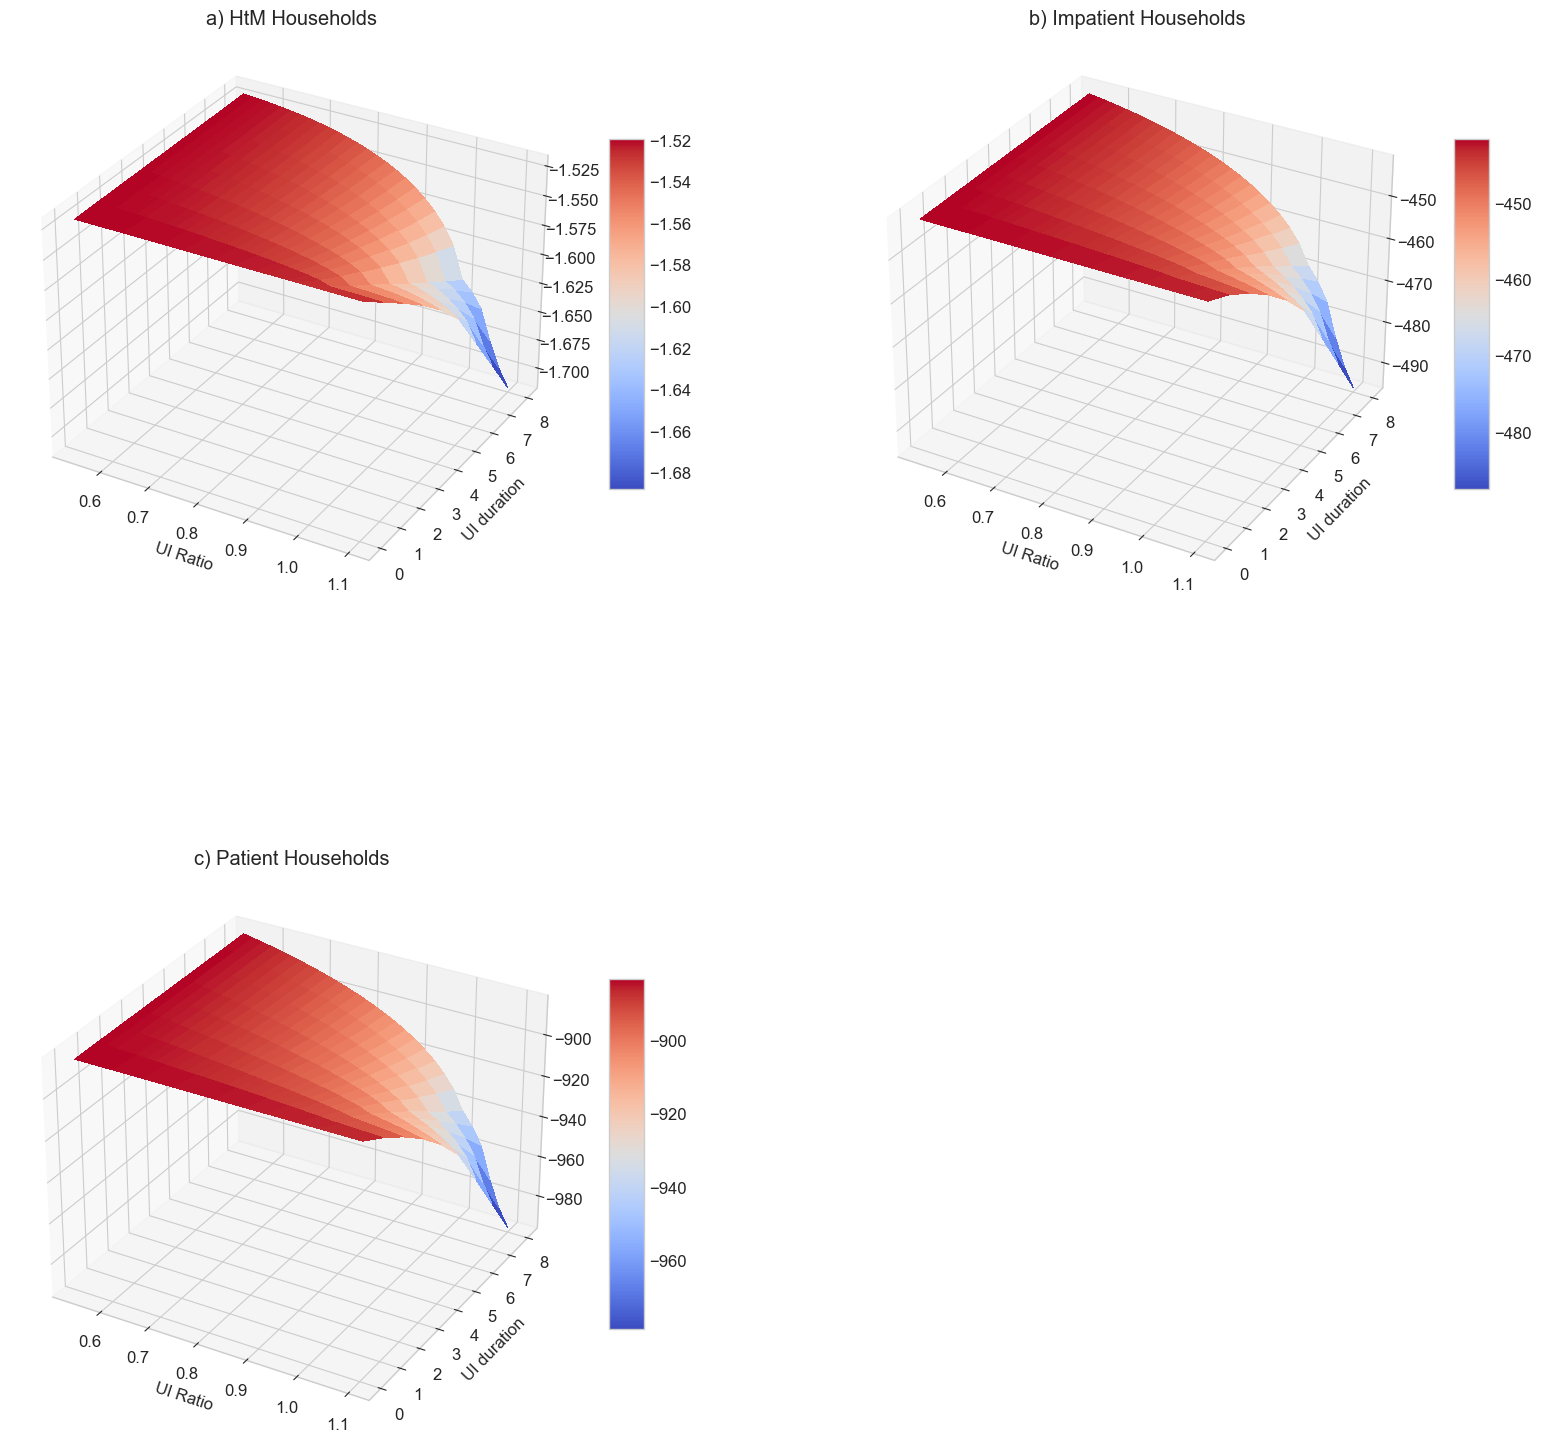

In [15]:
# Depct results

from mpl_toolkits.mplot3d.axes3d import get_test_data


# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(20,20))

# set up the axes for the first plot
ax = fig.add_subplot(2, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
Y = UI_dur_vectot[:]
X = UI_ratio_vectot[:]

X, Y = np.meshgrid(X, Y)

Z = V_tot[:,:,0]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_title(f'a) HtM Households')

ax.set_xlabel('UI Ratio')
ax.set_ylabel('UI duration')


ax = fig.add_subplot(2, 2, 2, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
Y = UI_dur_vectot[:]
X = UI_ratio_vectot[:]

X, Y = np.meshgrid(X, Y)

Z = V_tot[:,:,1]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title(f'b) Impatient Households')

ax.set_xlabel('UI Ratio')
ax.set_ylabel('UI duration')

ax = fig.add_subplot(2, 2, 3, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
Y = UI_dur_vectot[:]
X = UI_ratio_vectot[:]

X, Y = np.meshgrid(X, Y)

Z = V_tot[:,:,2]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_title(f'c) Patient Households')

ax.set_xlabel('UI Ratio')
ax.set_ylabel('UI duration')

## For Gini Coefficients

In [8]:
# Calculate

UI_ratio_vectot = np.linspace(0.92,1.04,7)
UI_dur_vectot = np.linspace(4.0,12.0,9)

# Aggregate value function
V_tot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot), len(par.beta_grid)))

# For fractiles
V_ftot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot), par.Nfix, par.Nz, par.Na))
D_ftot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot), par.Nfix, par.Nz, par.Na))

# For gini
gini_tot = np.nan + np.zeros((len(UI_dur_vectot),len(UI_ratio_vectot)))



for i in range(len(UI_dur_vectot)):
    for j in range(len(UI_ratio_vectot)):
        par.UI_duration = UI_dur_vectot[i]
        par.UI_ratio_high = UI_ratio_vectot[j]
        
        print(par.UI_duration)
        print(par.UI_ratio_high)
        
        model.find_ss()
        
        #Value function
        V_tot[i,j] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]  
    
        # For fractiles
        V_ftot[i,j] = ss.V
        D_ftot[i,j] = ss.D
    
        # Gini
        if np.min(ss.D) < 0:
            gini_tot[i,j] = 0.0
        else:
            _, _, gini_tot[i,j] = gini(ss,par)

4.0
0.92
4.0
0.9400000000000001
4.0
0.9600000000000001
4.0
0.98
4.0
1.0
4.0
1.02
4.0
1.04
5.0
0.92
5.0
0.9400000000000001
5.0
0.9600000000000001
5.0
0.98
5.0
1.0
5.0
1.02
5.0
1.04
6.0
0.92
6.0
0.9400000000000001
6.0
0.9600000000000001
6.0
0.98
6.0
1.0
6.0
1.02
6.0
1.04
7.0
0.92
7.0
0.9400000000000001
7.0
0.9600000000000001
7.0
0.98
7.0
1.0
7.0
1.02
7.0
1.04
8.0
0.92
8.0
0.9400000000000001
8.0
0.9600000000000001
8.0
0.98
8.0
1.0
8.0
1.02
8.0
1.04
9.0
0.92
9.0
0.9400000000000001
9.0
0.9600000000000001
9.0
0.98
9.0
1.0
9.0
1.02
9.0
1.04
10.0
0.92
10.0
0.9400000000000001
10.0
0.9600000000000001
10.0
0.98
10.0
1.0
10.0
1.02
10.0
1.04
11.0
0.92
11.0
0.9400000000000001
11.0
0.9600000000000001
11.0
0.98
11.0
1.0
11.0
1.02
11.0
1.04
12.0
0.92
12.0
0.9400000000000001
12.0
0.9600000000000001
12.0
0.98
12.0
1.0
12.0
1.02
12.0
1.04


Text(0.5, 0.5, 'UI duration')

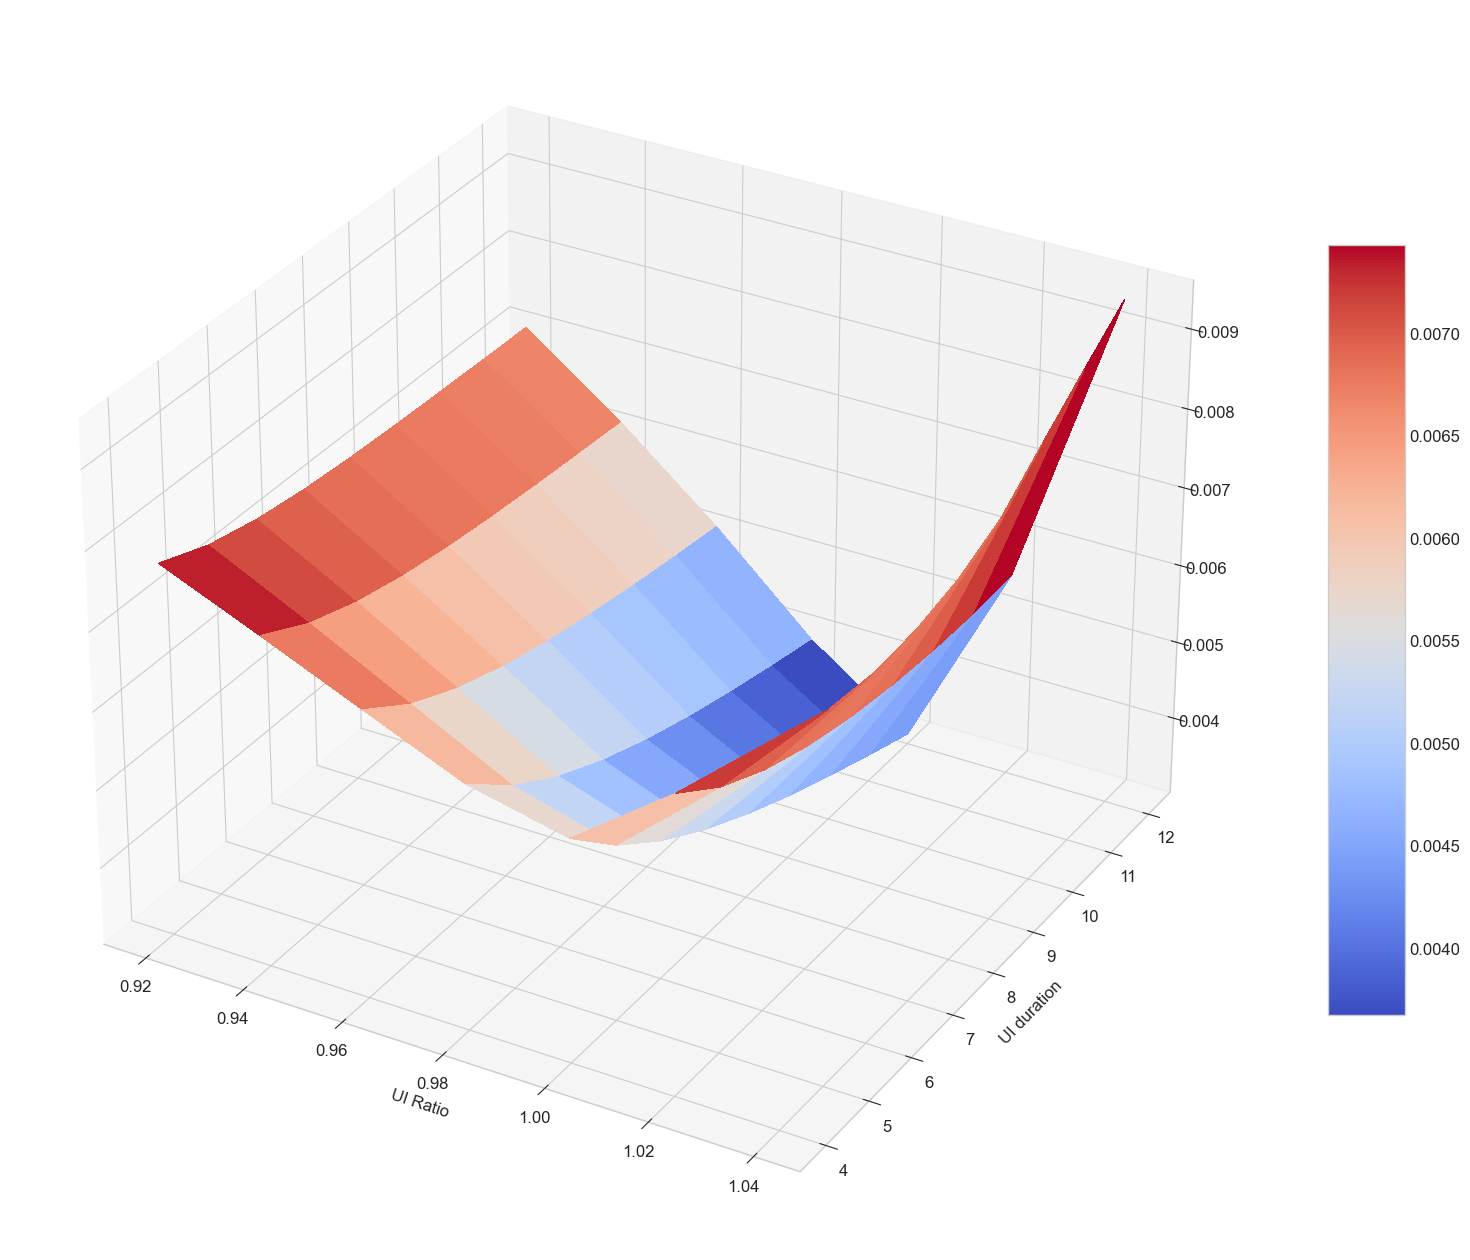

In [9]:
from mpl_toolkits.mplot3d.axes3d import get_test_data

# fig = plt.figure(figsize=plt.figaspect(1.0))
fig = plt.figure(figsize=(20,20))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
Y = UI_dur_vectot[:]
X = UI_ratio_vectot

X, Y = np.meshgrid(X, Y)

Z = gini_tot[:,:]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_xlabel('UI Ratio')
ax.set_ylabel('UI duration')